# Olymploration: Who wins the most medals at the Olympics?

<div style="background-color: #FFFFE0; border: 2px solid #FFD700; padding: 20px;">
Rooted in rich history, symbolism and values associated with the Olympic games, Olympic medals are considered highly prestigious, often representing the pinnacle of athletic achievement. Winning an Olympic medal is a recognition of excellence on the international stage, and it often holds cultural and national significance. It is an opportunity for athletes from all nations, big or small, to transcend national boundaries and compete together. This tradition began in 1896 in Athens, Greece and with the exception of the games not being held due to the two world wars, the Summer games have been held every 4 years. The first Winter Olympics were held in Chamonix, France, in 1924. The goal of this project is to predict which country wins the most medals at the Olympic games. 
    </div>
    



Here is a flowchart of our process:
![Alt text](flowchart.png)

We will now import the packages needed.


In [831]:
#import packages needed

import os
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import os
import glob2 as glob
import missingno as msno
import plotly.express as px
import warnings
warnings.filterwarnings("ignore")
from collections import Counter
import numpy as np
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression 
from sklearn.linear_model import Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import PredefinedSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error 
from sklearn.metrics import r2_score
from sklearn import preprocessing 
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.ensemble import VotingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import xgboost as xgb
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, f1_score, auc
import xgboost as xgb
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, precision_score, recall_score
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.inspection import permutation_importance

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.options.display.float_format = '{:,.5f}'.format

We will now import the data files needed:

In [573]:
#read in files
relative_path = "data/raw/*.csv" 
file_list = glob.glob(relative_path)

dataframes = []


if not file_list:
    print("No CSV files found in the specified path.")
else:
    file_list.sort() #to stop the order from changing

    # Loop through the sorted file list and read each CSV file into a df
    for file in file_list:
        try:
            df = pd.read_csv(file)
            dataframes.append(df)
        except Exception as e:
            print(f"Error reading file {file}: {e}")

#name the dfs
df_athletes = dataframes[0]
df_event_results = dataframes[1]
df_medals = dataframes[2]
df_results = dataframes[3]
df_country = dataframes[4]
df_games = dataframes[5]
df_gdp_mean = dataframes[6]
df_pop_mean = dataframes[7]

<div style="background-color: #FFFFE0; border: 2px solid #FFD700; padding: 20px;">
The data for the project was originally sourced from Olympedia which is a website that provides data and statistics on the Olympic games held in the past. The data comprises several csv files which include the following:
<br><br>
<strong>Games</strong> - venue, start and end dates of historical editions of the Olympic Games
<br>
<strong>Countries</strong> - list of countries
<br>
<strong>Athletes</strong> - name, country, height, weight, birthdate, etc.
<br>
<strong>Medals</strong> - medals tally by country for each year the games were held
<br>
<strong>Results</strong> - description of results by event
<br>
<strong>Event Results</strong> - results by event/sport including name of the winner
    </div>

In [574]:
#naming the dataframes
dataframes = {'df_athletes': df_athletes, 
       'df_country': df_country, 
       'df_event_results': df_event_results, 
       'df_games': df_games, 
       'df_medals': df_medals, 
       'df_results': df_results,
             'df_gdp_mean' : df_gdp_mean,
             'df_pop_mean' : df_pop_mean}

## EDA

Before we begin analyzing, we would like to check each dataframe for missing values:

In [575]:
#check missing values
def check_missing_values(df):
    return df.isnull().sum()


# check_missing_values(df_event_results)
# check_missing_values(df_country)
# check_missing_values(df_games)
# check_missing_values(df_athletes)
# check_missing_values(df_medals)
# check_missing_values(df_results)

def count_na(df):
    def helper(val):
        return val == 'na'
    return df.applymap(helper).sum() / df.shape[0]

# for key, value in dataframes.items():
#     print(f'\n\n{key}\n\n')
#     print(count_na(value))

There are missing values for end_Date, start_date if the games were not held. These missing values will not affect our analysis.
<br> <br>
Let's check the data to see if it is equally distributed between the Summer and Winter games:

In [576]:
# do we have winter olympics available as much? 
dict(Counter([i[5:] for i in df_games['edition'].unique()]))

{'Summer Olympics': 35,
 'Winter Olympics': 27,
 'Equestrian': 1,
 'Intercalated': 1}

Can an athlete take part in several events?


In [577]:
# one athlete can take part in several events
df_event_results.groupby(['edition', 'country_noc'])['athlete'].unique().reset_index(name='unique_athletes').assign(athlete_count=lambda x: x['unique_athletes'].apply(len)).head()


,edition,country_noc,unique_athletes,athlete_count
0,1896 Summer Olympics,AUS,"[Teddy Flack, George Stuart Robertson]",2
1,1896 Summer Olympics,AUT,"[Adolf Schmal, Otto Herschmann, Paul Neumann]",3
2,1896 Summer Olympics,BUL,[Charles Champaud],1
3,1896 Summer Olympics,DEN,"[Viggo Jensen, Eugen Schmidt, Holger Nielsen, Charles Winckler]",4
4,1896 Summer Olympics,FRA,"[Adolphe Grisel, Jean Tournois, Louis Adler, Alexandre Tuffèri, Frantz Reichel, Georges de la Nézière, Albin Lermusiaux, Léon Flameng, Paul Masson, Hatté, Gustave de Lafreté, Eugène Henry Gravelotte, Henri Callot, Henri de Laborde, Jean-Joseph Renaud, Joanni Perronet, J. Defert, André Vacherot]",18


In [580]:
#total medals 

df_medals_agg = df_medals.groupby('country')[['gold', 'silver', 'bronze', 'total']].sum()
df_medals_agg.describe()

,gold,silver,bronze,total
count,154.00000,154.00000,154.00000,154.00000
mean,43.83766,43.66883,46.59091,134.09740
std,121.13718,105.51443,100.82727,325.59648
min,0.00000,0.00000,0.00000,1.00000
25%,0.00000,1.00000,1.00000,3.00000
50%,3.00000,4.50000,6.00000,13.00000
75%,26.75000,33.50000,36.00000,98.50000
max,"1,194.00000",970.00000,845.00000,"3,009.00000"


<div style="background-color: #FFFFE0; border: 2px solid #FFD700; padding: 20px;">
<strong><i>Who has won the most medals? </i> </strong>

Historically, USA, the Soviet Union, Germany, Great Britain and France have won the most medals at the Olympics.The Soviet Union won the second most at 1204 followed by Germany at 1098. In terms of gold and silver medals won, USA leads by a mile.  USA should be considered an outlier while modeling.  The table above shows the descriptive statistics for the medals data. As you can see, the lower 75% of countries have historically won a total of only 98 medals which confirms that only a handful of countries dominate at the games.
    </div>

In [581]:
#historically, who won the most medals?? 

df_medals2 = df_medals.groupby('country_noc')[['total','gold', 'silver', 'bronze']].sum()
df_medals2.reset_index(inplace=True)


top5_rows = df_medals2.nlargest(5, 'total')

top5_countries = top5_rows['country_noc'].tolist()
top5_medals = top5_rows['total'].tolist()

print(f"The top 5 countries are: {top5_countries}")
print(f"The corresponding counts are: {top5_medals}")

The top 5 countries are: ['USA', 'URS', 'GER', 'GBR', 'FRA']
The corresponding counts are: [3009, 1204, 1098, 989, 950]


In [582]:
# Melt the DataFrame to long format 
top_50 = df_medals2.nlargest(50, 'total')
df_medals3 = top_50.drop(['total'], axis=1)
df_medals_melted = pd.melt(df_medals3, id_vars='country_noc', var_name='Medal', value_name='Count')

df_medals_melted.head()

,country_noc,Medal,Count
0,USA,gold,1194
1,URS,gold,473
2,GER,gold,355
3,GBR,gold,312
4,FRA,gold,287


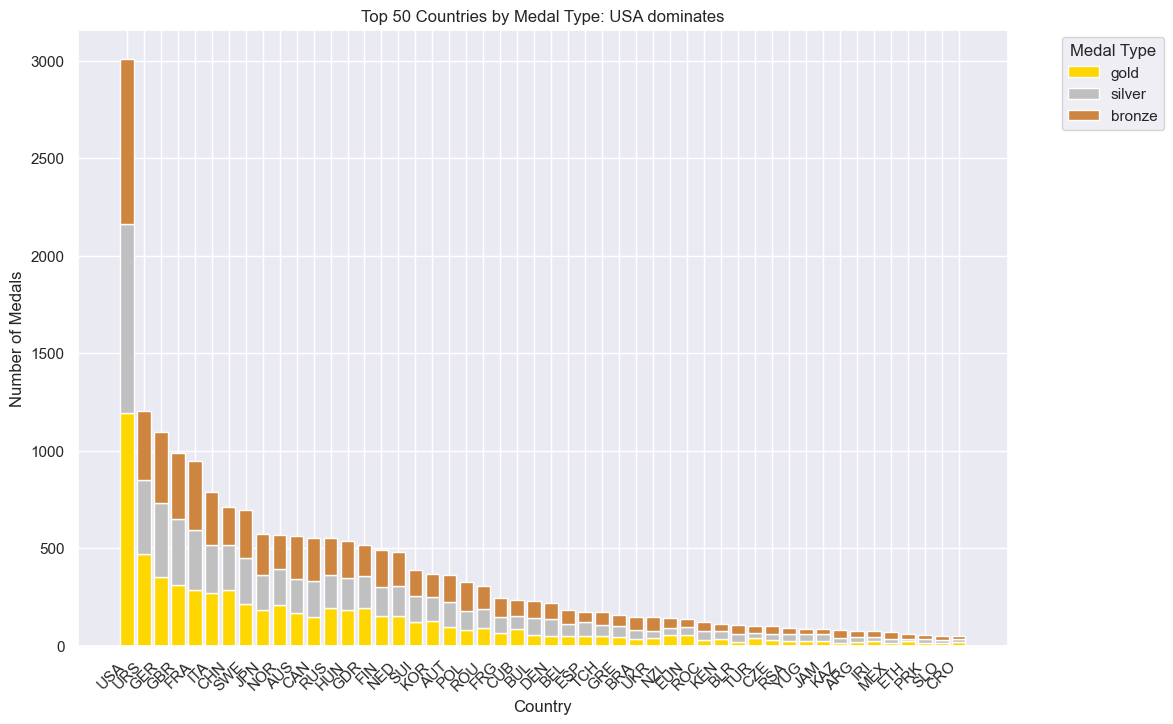

In [584]:
#Plot top 50 countries that won medals
df_stacked = df_medals_melted.pivot_table(index='country_noc', columns='Medal', values='Count', fill_value=0)

df_stacked_sorted = df_stacked.sum(axis=1).sort_values(ascending=False).index
df_stacked = df_stacked.loc[df_stacked_sorted]


colors = {'gold': 'gold', 'silver': 'silver', 'bronze': 'peru'}


bar_width = 0.8

plt.figure(figsize=(12, 8))

bottom_values = np.zeros(len(df_stacked.index))

for medal_type, color in colors.items():
    plt.bar(df_stacked.index, df_stacked[medal_type], color=color, label=medal_type, width=bar_width, bottom=bottom_values)
    bottom_values += df_stacked[medal_type]  

plt.title('Top 50 Countries by Medal Type: USA dominates')
plt.xlabel('Country')
plt.ylabel('Number of Medals')
plt.xticks(rotation=45, ha='right') 
plt.legend(title='Medal Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


<strong><i> Has anything changed in the past 20 years? Do countries continue to remain dominant?</i></strong>

In [598]:
#has anything changed in the past 20 years?

#filter df to include 2004 Athens games onwards

df_last20 = df_medals[['year', 'country', 'total']].copy()

df_last20 = df_last20.loc[df_last20['year'] >= 1992]

In [599]:
total_by_country = df_last20.groupby('country')['total'].sum()
top_10_countries = total_by_country.sort_values(ascending=False).head(12)
top_10_countries_list = total_by_country.sort_values(ascending=False).head(12).index.tolist()

recent_games  = df_last20[df_last20['country'].isin(top_10_countries_list)]


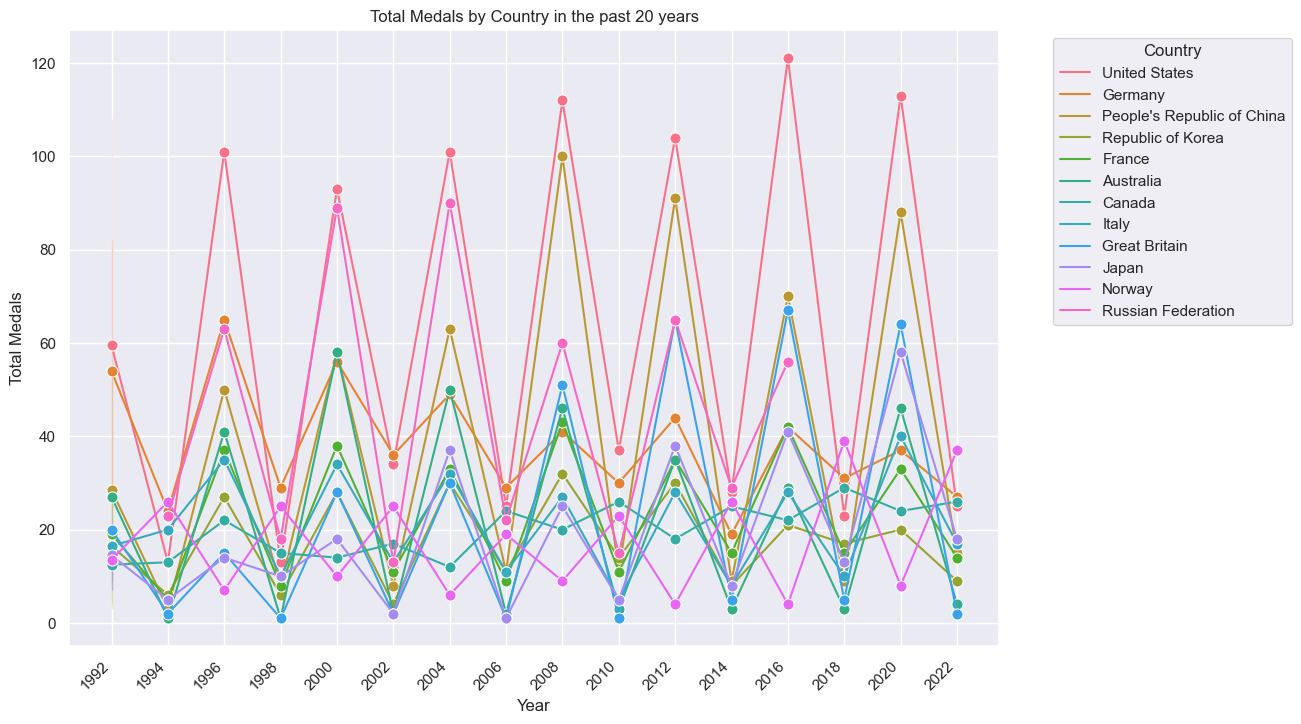

In [587]:
plt.figure(figsize=(12, 8))
sns.lineplot(x='year', y='total', hue='country', data=recent_games, marker='o', markersize=8)

plt.xticks(recent_games['year'].unique())

plt.title('Total Medals by Country in the past 20 years')
plt.xlabel('Year')
plt.ylabel('Total Medals')
plt.legend(title='Country', bbox_to_anchor=(1.05, 1), loc='upper left')  
plt.xticks(rotation=45, ha='right')  
plt.show()

 <div style="background-color: #FFFFE0; border: 2px solid #FFD700; padding: 20px;">
In the past 30 years, USA continues to remain extremely dominant at the Summer Olympics (first Summer Olympics in the graph took place in 1992 and first Winter Olympics took place in 1994). The Russian Federation/Soviet Union which historically had the second most medals is not as dominant as before. In the past 4 editions of the Summer games, China has won the second most number of medals, bypassing Russia. Great Britain has also steadily increased their medal count in the past 30 years.
However at the Winter Olympics, Norway's athletes have been outpacing the U.S. and Germany.
</div>

<strong> <i>Do GDP and Population have an impact on the number of medals won?<i><strong>

We are going to use the past 10 year avg as a proxy to check the relationship.

In [592]:
#GDP and population 
df_country_gdp = pd.read_csv('data/raw/country_gdp.csv')


In [593]:
df_country_gdp.drop(['Indicator Name', 'Indicator Code'], axis=1, inplace=True)

In [594]:
df_country2 = pd.merge(df_country, df_country_gdp, how='left', left_on='country', right_on='Country Name')

exclude_columns = ['country_noc', 'country', 'Country Code', 'Country Name']
numeric_columns = df_country2.select_dtypes(include=['number']).columns

# Filter out columns to exclude from the division
columns_to_divide = numeric_columns.difference(exclude_columns)

# Perform division only on numeric columns
df_country2[columns_to_divide] = df_country2[columns_to_divide].div(1e9)


In [595]:
df_country2.iloc[:, -10:] = df_country2.iloc[:, -10:].apply(pd.to_numeric, errors='coerce')

# # Calculate the mean of the last 10 columns while ignoring NaN values
df_country2['mean_gdp_last_10yr_bn'] = df_country2.iloc[:, -10:].mean(axis=1, skipna=True)


In [597]:
missing_values_gdp = df_country2['mean_gdp_last_10yr_bn'].isnull().sum()

<div style="background-color: #FFFFE0; border: 2px solid #FFD700; padding: 20px;">
We would like to use GDP and Population  as additional independent variables in our models and examine whether it has an impact on the medals tally or not. One of the limitations we are facing with the World Bank data is that it is available only 1960 onwards with data for some countries being available much later. The data for the past 10 years is available and we plan on using the 10yr mean as a proxy for GDP in our model. An alternative way is to create dummy variables after categorizing the countries based on the range of their population, eg- high, medium, low. The chart below shows the countries with the highest mean GDP over the past 10 years and  we guess that GDP  is positively correlated with the medals count.
    </div>

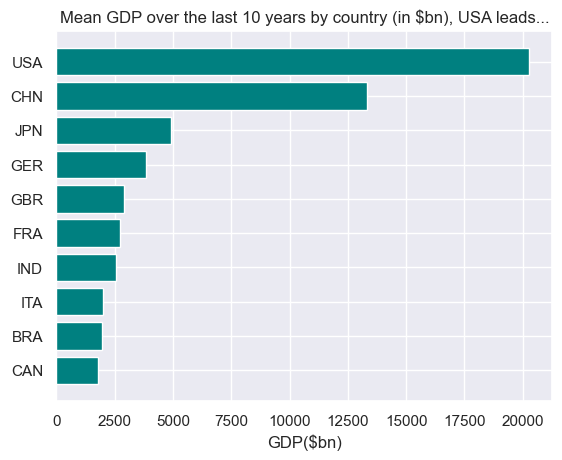

In [600]:
df_sorted = df_country2.sort_values(by='mean_gdp_last_10yr_bn', ascending=False)
top_10_values = df_sorted.head(10)

plt.barh(top_10_values['country_noc'], top_10_values['mean_gdp_last_10yr_bn'], color='teal')
plt.xlabel('GDP($bn)')
plt.title('Mean GDP over the last 10 years by country (in $bn), USA leads...')
plt.gca().invert_yaxis()
plt.show()

In [602]:
df_pop = pd.read_csv('data/raw/country_population.csv')
df_pop.drop(['Country Name',  'Indicator Name', 'Indicator Code'], axis=1, inplace=True)

In [603]:
#df_pop.drop(['Indicator Name', 'Indicator Code'], axis=1, inplace=True)
df_pop2 = pd.merge(df_country, df_pop, how='left', left_on='country', right_on='Country_Updated')


In [604]:
exclude_columns = ['country_noc', 'country', 'Country Code', 'Country_Updated']
df_pop2.loc[:, df_pop2.columns.difference(exclude_columns)] /= 1e6 # convert to millions 

In [605]:
#following a similar approach of taking the 10 year mean
df_pop2['mean_pop_last_10yr_mm'] = df_pop2.iloc[:, -10:].mean(axis=1)
df_country_pop = df_pop2[['country_noc', 'country', 'Country Code', 'mean_pop_last_10yr_mm']].copy()
#df_country_pop.to_clipboard(index=False)

In [606]:
missing_values_pop = df_country_pop['mean_pop_last_10yr_mm'].isnull().sum()
missing_values_pop

51

<div style="background-color: #FFFFE0; border: 2px solid #FFD700; padding: 20px;">
We followed a similar approach for Population and calculated the 10yr mean as a proxy. Apart from China, USA, Russia, Japan, other countries with the highest mean population generally do not do well at the Games. Having a larger population could also mean less resources to invest in training athletes and could in fact, have a negative impact on medals won.
    </div>

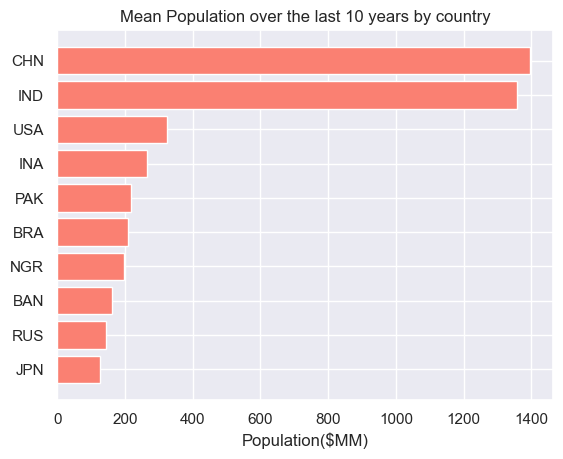

In [607]:
df_sorted_pop = df_country_pop.sort_values(by='mean_pop_last_10yr_mm', ascending=False)
top_10_values_pop = df_sorted_pop.head(10)


plt.barh(top_10_values_pop['country_noc'], top_10_values_pop['mean_pop_last_10yr_mm'], color='salmon')
plt.xlabel('Population($MM)')
plt.title('Mean Population over the last 10 years by country')
plt.gca().invert_yaxis()
plt.show()

In [608]:
#group by total medals for each country

df_grouped = df_medals.groupby('country_noc')['total'].sum()
df_grouped = pd.DataFrame(df_grouped)
df_grouped.reset_index(inplace=True)

In [610]:
#check correlation between variables and medals tally

df_merged = pd.merge(df_grouped, df_country2[['country_noc','mean_gdp_last_10yr_bn']
                                                                        ],how='left', on='country_noc')

df_merged2 = pd.merge(df_merged, df_country_pop[['country_noc','mean_pop_last_10yr_mm']
                                                                        ],how='left', on='country_noc')

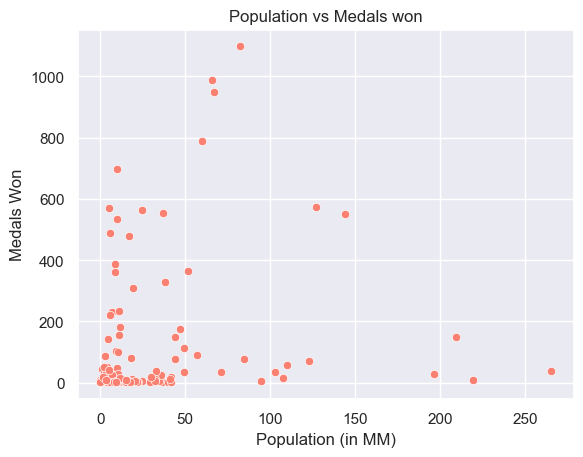

In [611]:
#exclude China, India, USA
excluded_countries = ['CHN', 'IND', 'USA']
df_filtered = df_merged2[~df_merged2['country_noc'].isin(excluded_countries)]
sns.scatterplot(y='total', x='mean_pop_last_10yr_mm', data=df_filtered, color='salmon')

# Add labels and title
plt.xlabel('Population (in MM)')
plt.ylabel('Medals Won')
plt.title('Population vs Medals won')

# Show the plot
plt.show()

<div style="background-color: #FFFFE0; border: 2px solid #FFD700; padding: 20px;">
We excluded China and USA along with India which has the second highest 10 yr mean population and it appears that some countries with smaller populations have won more medals. However, there are also countries that are very tiny, have very small populations and hence, have very low participation at the Olympics.
    </div>

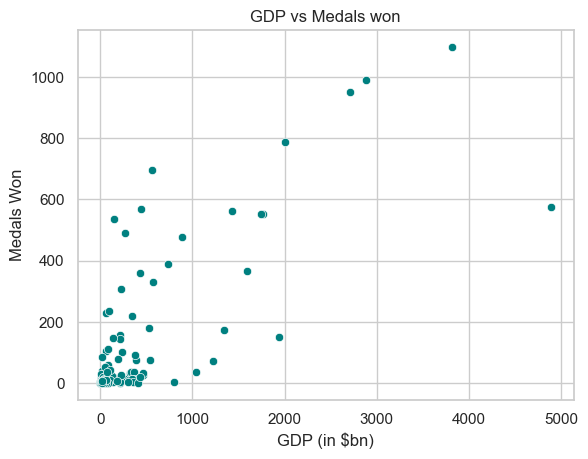

In [636]:
sns.scatterplot(y='total', x='mean_gdp_last_10yr_bn', data=df_filtered, color='teal')
# Add labels and title
plt.xlabel('GDP (in $bn)')
plt.ylabel('Medals Won')
plt.title('GDP vs Medals won')

# Show the plot
plt.show()

<div style="background-color: #FFFFE0; border: 2px solid #FFD700; padding: 20px;">
The scatter plot confirms that GDP is positvely correlated with medals one. We still have countries with missing GDP but they are either very small or nations that had a name change, we will be excluding those records.
    </div>

<strong>Let us get the sport for each athlete...</strong>

In [637]:
# join athletes with events to get the sport for each athlete, it is not in df_athletes

df_athletes_sport = pd.merge(df_athletes[['name', 'sex', 'height', 'weight']],
                              df_event_results[['athlete', 'sport']], left_on='name', right_on='athlete', how='left')

df_athletes_sport.head()


,name,sex,height,weight,athlete,sport
0,Károly Teppert,Male,na,na,Károly Teppert,Cycling Road
1,Károly Teppert,Male,na,na,Károly Teppert,Cycling Road
2,Andrzej Socharski,Male,173.0,72,Andrzej Socharski,Shooting
3,Nathalie Wunderlich,Female,170.0,50,Nathalie Wunderlich,Swimming
4,Nathalie Wunderlich,Female,170.0,50,Nathalie Wunderlich,Swimming


In [638]:
df_athletes_sport = df_athletes_sport.dropna()

In [639]:
df_athletes_sport['height'] = pd.to_numeric(df_athletes_sport['height'], errors='coerce')  
df_athletes_sport['weight'] = pd.to_numeric(df_athletes_sport['weight'], errors='coerce')  

# Group by 'sport' and calculate the average height and weight
average_data = df_athletes_sport.groupby(['sport', 'sex'])[['height', 'weight']].mean().reset_index()

#select a few sports 

select_sports = ['Archery', 'Artistic Gymnastics', 'Athletics',
                'Badminton', 'Boxing', 'Cross Country Skiing',
                'Cycling Track', 'Diving', 'Equestrian Dressage',
                'Fencing', 'Hockey', 'Judo',
                 'Rowing', 'Shooting', 'Handball',
                 'Swimming', 'Triathlon', 'Volleyball',
                 'Weightlifting', 'Wrestling', 'Basketball', 'Table Tennis', 'Tennis'
                ]

#keep only selected sports
mask = average_data['sport'].isin(select_sports) 
selected_df = average_data[mask]

<strong><i>How does an athlete’s height and weight affect their choice of sport?<strong><i>

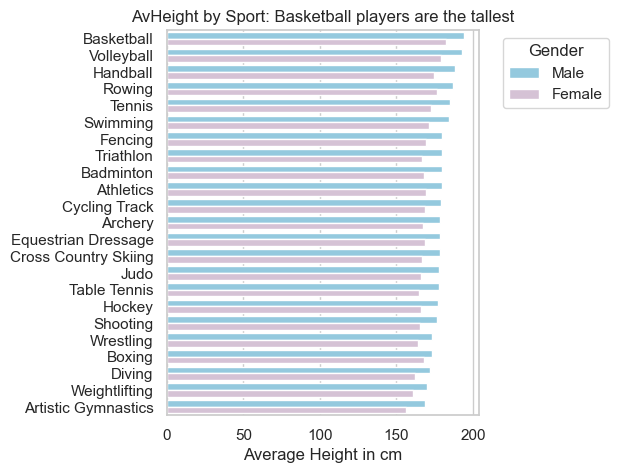

In [640]:
# Sort  in descending order
average_height_by_sport = selected_df.sort_values(by='height', ascending=False)
average_height_by_sport.dropna(inplace=True)

colors = {'Female': 'thistle', 'Male': 'skyblue'}

plt.figure(figsize=(5, 5))
sns.barplot(y='sport', x='height', hue='sex', data=average_height_by_sport, palette=colors)
plt.title('AvHeight by Sport: Basketball players are the tallest')
plt.xlabel('Average Height in cm')
plt.ylabel('')
plt.legend(title='Gender', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.subplots_adjust(right=0.75)
plt.show()

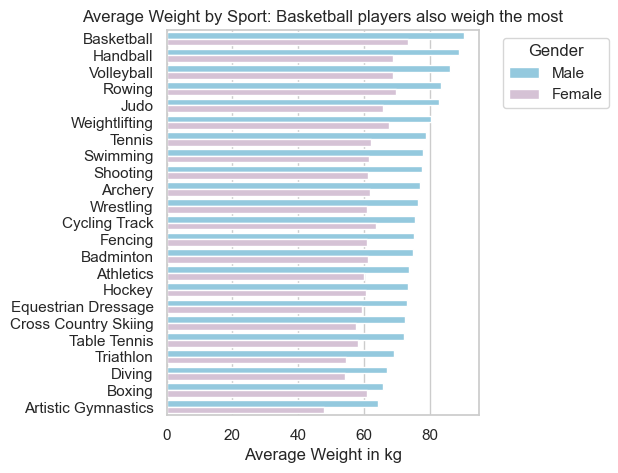

In [641]:
# Sort weight in descending order
average_weight_by_sport = selected_df.sort_values(by='weight', ascending=False)
average_weight_by_sport.dropna(inplace=True)

colors = {'Female': 'thistle', 'Male': 'skyblue'}

plt.figure(figsize=(5, 5))
sns.barplot(y='sport', x='weight', hue='sex', data=average_weight_by_sport, palette=colors)
plt.title('Average Weight by Sport: Basketball players also weigh the most')
plt.xlabel('Average Weight in kg')
plt.ylabel('')
plt.legend(title='Gender', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.subplots_adjust(right=0.75)
plt.show()

<div style="background-color: #FFFFE0; border: 2px solid #FFD700; padding: 20px;">
We selected some of the most popular events at the Olympics to see if there is any obvious trend in the height and weight of athletes competing in those sports. The charts above show the average height and weight of all the athletes playing a particular sport, missing records were excluded. Basketball players tend to be the tallest and also weigh the most but the difference in the average height across sports is minimal for both males and females. On the other hand, the difference in weight between males and females across the different sports is more obvious. Furthermore, gymnasts, boxers and divers weigh less than athletes playing basketball or handball.
    </div>

<strong><i>Which countries do better at team vs individual events?</i></strong>

In [618]:
#which countries do better at team vs individual events

df_event_results2 = df_event_results[df_event_results['medal'] != 'na']

In [619]:
#group by country

df_team = df_event_results2.groupby(['country_noc', 'isTeamSport']).result_id.count().reset_index()
df_team = pd.DataFrame(df_team)


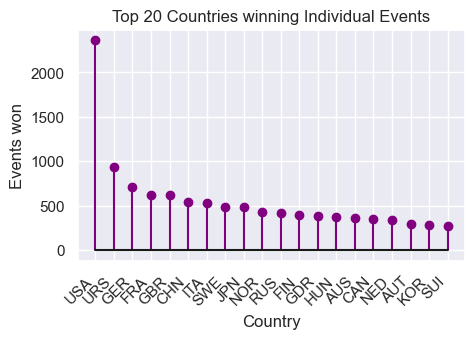

In [620]:
#filter by team vs individual
filtered_data = df_team[df_team['isTeamSport'] == False]

top_20_countries = filtered_data.groupby('country_noc')['result_id'].sum().nlargest(20).index

top_20_data = filtered_data[filtered_data['country_noc'].isin(top_20_countries)]

top_20_data = top_20_data.sort_values(by='result_id', ascending=False)

#lollipop chart
plt.figure(figsize=(5, 3))
plt.stem(top_20_data['country_noc'], top_20_data['result_id'], basefmt='k-', use_line_collection=True, markerfmt='purple',
         linefmt='purple')
plt.title('Top 20 Countries winning Individual Events')
plt.xlabel('Country')
plt.ylabel('Events won')
plt.xticks(rotation=45, ha='right')


plt.show()

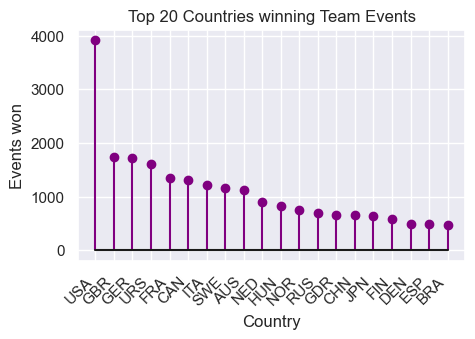

In [621]:
filtered_data2 = df_team[df_team['isTeamSport'] == True]

top_20_countries2 = filtered_data2.groupby('country_noc')['result_id'].sum().nlargest(20).index


top_20_data2 = filtered_data2[filtered_data2['country_noc'].isin(top_20_countries2)]

# Sort the data for better visualization
top_20_data2 = top_20_data2.sort_values(by='result_id', ascending=False)

# Create a lollipop chart
plt.figure(figsize=(5,3))
plt.stem(top_20_data2['country_noc'], top_20_data2['result_id'], basefmt='k-', use_line_collection=True, markerfmt='purple',
         linefmt='purple')
plt.title('Top 20 Countries winning Team Events')
plt.xlabel('Country')
plt.ylabel('Events won')
plt.xticks(rotation=45, ha='right')

# Show the plot
plt.show()

<div style="background-color: #FFFFE0; border: 2px solid #FFD700; padding: 20px;">
While the USA is an outlier doing well at both individual and team events, Great Britain comes next in terms of most medals won at team events. Countries like Canada, Australia, the Netherlands among others also happen to do better at team events than individual events.
    </div>

<strong><i>Who is the greatest Olympian of all time?<strong><i>

In [623]:
#greatest Olympian of all time 

greatest_olympian = df_event_results2.groupby(['athlete', 'sport', 'country_noc']).result_id.count().sort_values(ascending=False)
greatest_olympian = pd.DataFrame(greatest_olympian)
greatest_olympian.rename({'result_id':'medals_won'}, axis=1, inplace=True)
greatest_olympian.reset_index(inplace=True)


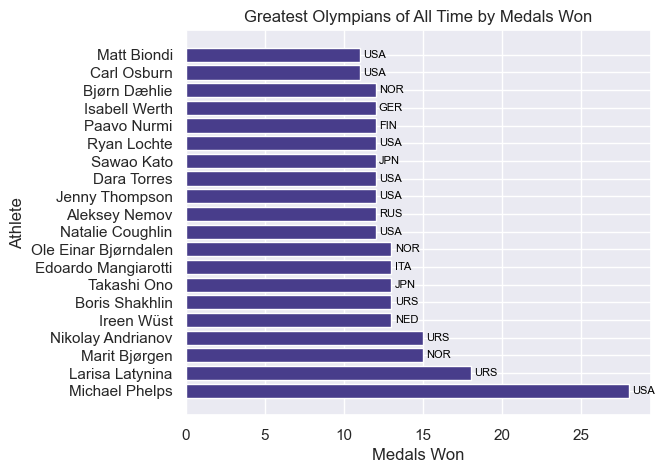

In [624]:
greatest_olympian2 = greatest_olympian.sort_values(by='medals_won', ascending=False)
greatest_olympian2 = greatest_olympian2.head(20)
plt.figure(figsize=(6, 5))
bars = plt.barh(greatest_olympian2['athlete'], greatest_olympian2['medals_won'], color='darkslateblue')
plt.xlabel('Medals Won')
plt.ylabel('Athlete')
plt.title('Greatest Olympians of All Time by Medals Won')

for bar, label in zip(bars, greatest_olympian2['country_noc']):
    plt.text(bar.get_width() + 0.2, bar.get_y() + bar.get_height() / 2, label, ha='left', va='center', color='black', fontsize=8)

plt.show()

<div style="background-color: #FFFFE0; border: 2px solid #FFD700; padding: 20px;">
Michael Phelps is well-known as the greatest Olympian of all time but in second place is Larisa Latynina, a gymnast from the former Soviet Union who won 18 medals. 25% of the top 20 are from the USA.
    <div>

<strong><i>Which gender wins more medals? </strong></i>

In [625]:
#which gender wins more medals
gender_medals = pd.merge(df_athletes[['name', 'sex']], df_event_results2[['athlete','medal', 'sport','result_id']],
                        left_on="name", right_on="athlete")
gender_medals2 = gender_medals.groupby('sex').athlete.count()
gender_medals2=pd.DataFrame(gender_medals2)
gender_medals2.reset_index(inplace=True)

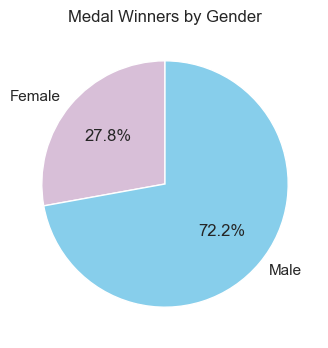

In [626]:
plt.figure(figsize=(4, 4))
sns.set(style="whitegrid")
plt.pie(gender_medals2['athlete'], labels=gender_medals2.sex, autopct='%1.1f%%', startangle=90,
        colors=['thistle', 'skyblue'])


plt.title('Medal Winners by Gender')

plt.show()


In [642]:
#gold medal winners

gender_gold = gender_medals[gender_medals['medal'] == 'Gold']

gender_gold2 = gender_gold.groupby('sex').athlete.count()
gender_gold2=pd.DataFrame(gender_gold2)
gender_gold2.reset_index(inplace=True)

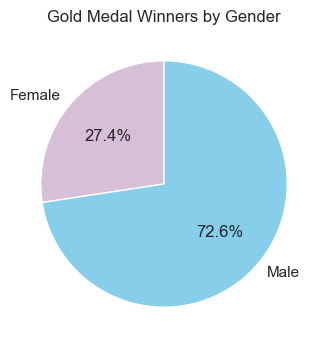

In [643]:
plt.figure(figsize=(4, 4))
sns.set(style="whitegrid")
plt.pie(gender_gold2['athlete'], labels=gender_gold2.sex, autopct='%1.1f%%', startangle=90,
        colors=['thistle', 'skyblue'])


plt.title('Gold Medal Winners by Gender')

plt.show()


<div style="background-color: #FFFFE0; border: 2px solid #FFD700; padding: 20px;">
72% of all medal winners are Male, with a similar stat for gold medal winners. This is expected given that the historical participation rate of female athletes  is 26%.
    </div>

In [644]:
gender_all = df_athletes.groupby('sex')['name'].count()

In [631]:
# how many athletes take part by country
df_event_results.groupby(['edition', 'country_noc'], as_index=False)['athlete'].count().head()

,edition,country_noc,athlete
0,1896 Summer Olympics,AUS,7
1,1896 Summer Olympics,AUT,10
2,1896 Summer Olympics,BUL,4
3,1896 Summer Olympics,DEN,25
4,1896 Summer Olympics,FRA,51


In [645]:
# one athlete can take part in several events
df_event_results.groupby(['edition', 'country_noc'])['athlete'].unique().reset_index(name='unique_athletes').assign(athlete_count=lambda x: x['unique_athletes'].apply(len)).head()


,edition,country_noc,unique_athletes,athlete_count
0,1896 Summer Olympics,AUS,"[Teddy Flack, George Stuart Robertson]",2
1,1896 Summer Olympics,AUT,"[Adolf Schmal, Otto Herschmann, Paul Neumann]",3
2,1896 Summer Olympics,BUL,[Charles Champaud],1
3,1896 Summer Olympics,DEN,"[Viggo Jensen, Eugen Schmidt, Holger Nielsen, Charles Winckler]",4
4,1896 Summer Olympics,FRA,"[Adolphe Grisel, Jean Tournois, Louis Adler, Alexandre Tuffèri, Frantz Reichel, Georges de la Nézière, Albin Lermusiaux, Léon Flameng, Paul Masson, Hatté, Gustave de Lafreté, Eugène Henry Gravelotte, Henri Callot, Henri de Laborde, Jean-Joseph Renaud, Joanni Perronet, J. Defert, André Vacherot]",18


<strong>Merge: Join medals and games</strong>

In [647]:
# df_medals['edition_id'].nunique()
# df_games['edition_id'].nunique()


# drop war and future events
df_games = df_games.drop(df_games[~df_games['edition_id'].isin(df_medals['edition_id'])].index)


df_games_medals = pd.merge(df_medals, pd.merge(df_games, df_country, on='country_noc', how='left'), on=['edition_id', 'edition', 'year'], how='left',
        suffixes=('_performing', '_host'))


In [648]:
#special or one time events
df_games_medals[(df_games_medals['edition_id'] == 4)|(df_games_medals['edition_id'] == 48)]

# drop the one-time events
df_games_medals = df_games_medals.drop(df_games_medals[(df_games_medals['edition_id'] == 4)|
                                                       (df_games_medals['edition_id'] == 48)].index)

In [649]:
df_games_medals.describe()

,edition_id,year,gold,silver,bronze,total
count,"1,782.00000","1,782.00000","1,782.00000","1,782.00000","1,782.00000","1,782.00000"
mean,31.85017,"1,980.58249",3.74355,3.72783,3.98148,11.45286
std,18.36267,32.06506,7.58711,6.44107,6.19451,19.51169
min,1.00000,"1,896.00000",0.00000,0.00000,0.00000,1.00000
25%,17.00000,"1,960.00000",0.00000,1.00000,1.00000,2.00000
50%,25.00000,"1,988.00000",1.00000,2.00000,2.00000,5.00000
75%,53.00000,"2,008.00000",4.00000,4.00000,5.00000,13.00000
max,62.00000,"2,022.00000",83.00000,85.00000,83.00000,248.00000


Let us do some additional EDA:

In [650]:
#some more eda

def eda_visualization(df):
    numerical_columns = df.select_dtypes(include='number').columns
    categorical_columns = df.select_dtypes(exclude='number').columns

    for column in numerical_columns:
        plt.figure(figsize=(12, 4))
        
        plt.subplot(1, 2, 1)
        sns.histplot(df[column], kde=True)
        plt.title(f'Distribution of {column}')
        
        plt.subplot(1, 2, 2)
        ax = sns.boxplot(data=df, x=column, showfliers=False)
        plt.title(f'Boxplot of {column} Without Outliers')
        
        def add_quartile_labels(ax):
            for line in ax.lines:
                x, y = line.get_xydata()[0]  
                ax.text(x, y, f"{x:.0f}", ha='left', va='center')
        
        add_quartile_labels(ax)

        plt.tight_layout()
        plt.show()

    for column in categorical_columns:
        plt.figure(figsize=(8, 4))
        categories_to_show = df[column].value_counts().index[:30]

        if not categories_to_show.empty:
            sns.countplot(data=df[df[column].isin(categories_to_show)], x=column, order=categories_to_show)

            for idx, count in enumerate(df[df[column].isin(categories_to_show)][column].value_counts()):
                plt.text(idx, count + 1, str(count), ha='center', va='bottom', fontsize=8)

            plt.title(f'Count of each category in {column}')
            plt.xticks(rotation=90, ha='right', fontsize=7)
            plt.tight_layout()
            plt.show()
        else:
            print(f"No categories to show for column {column}.")

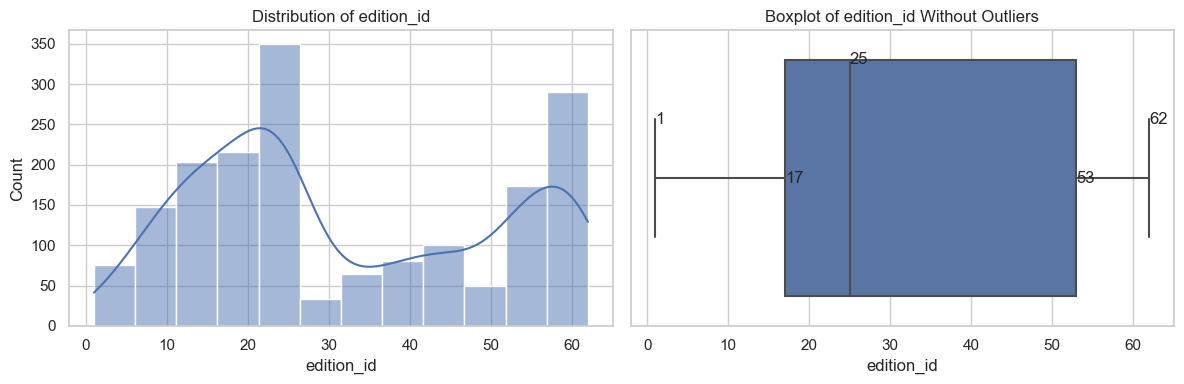

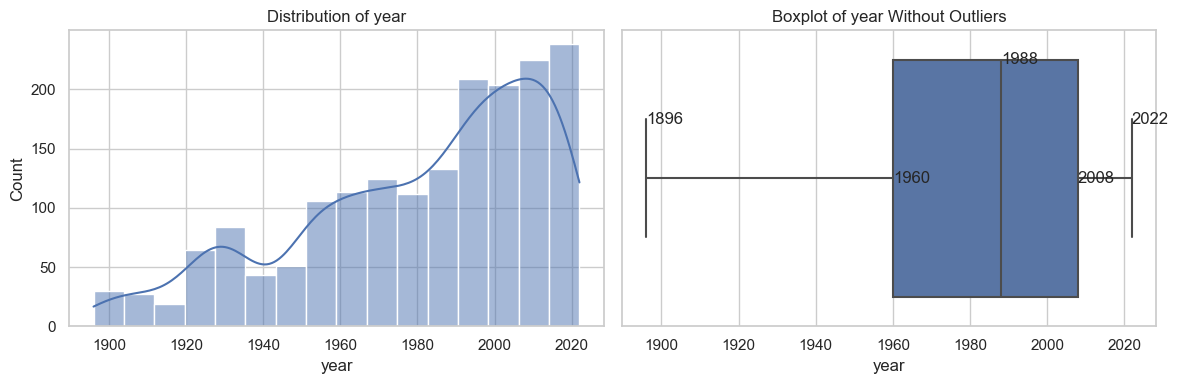

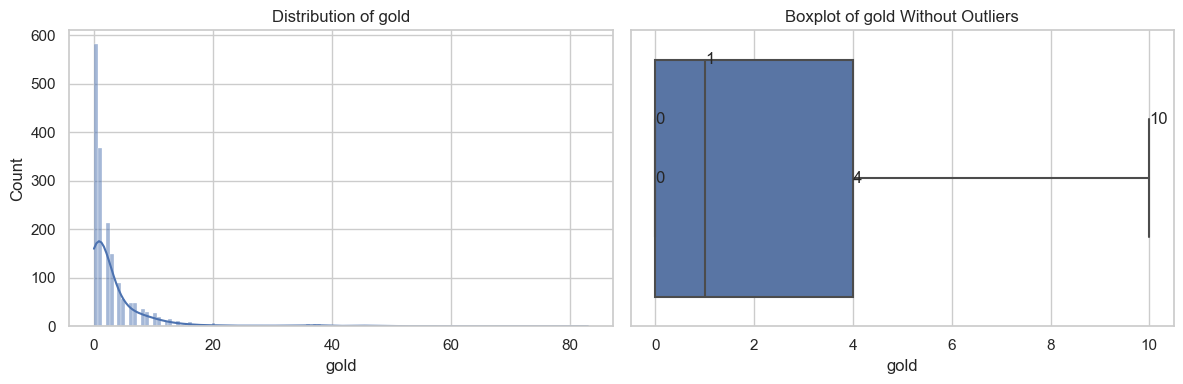

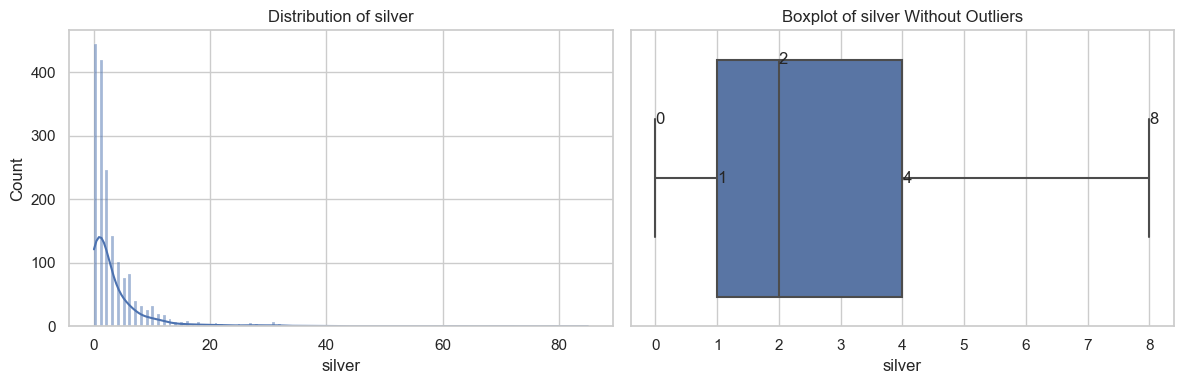

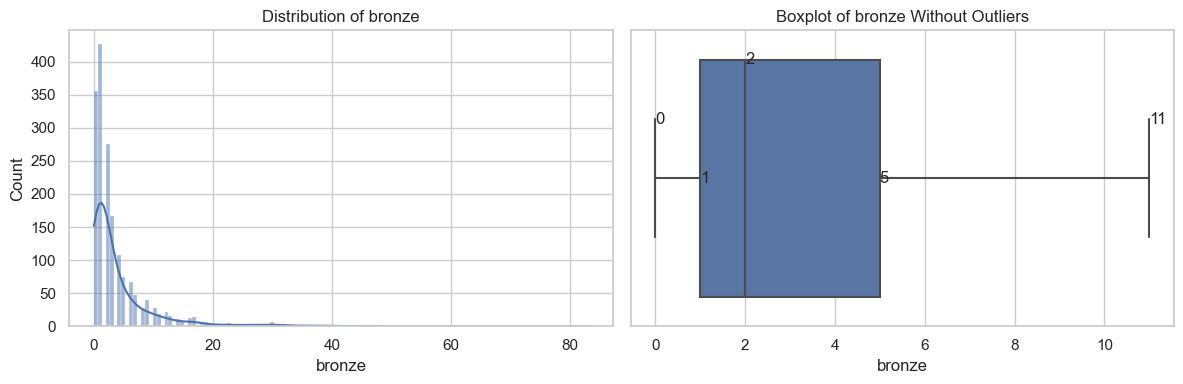

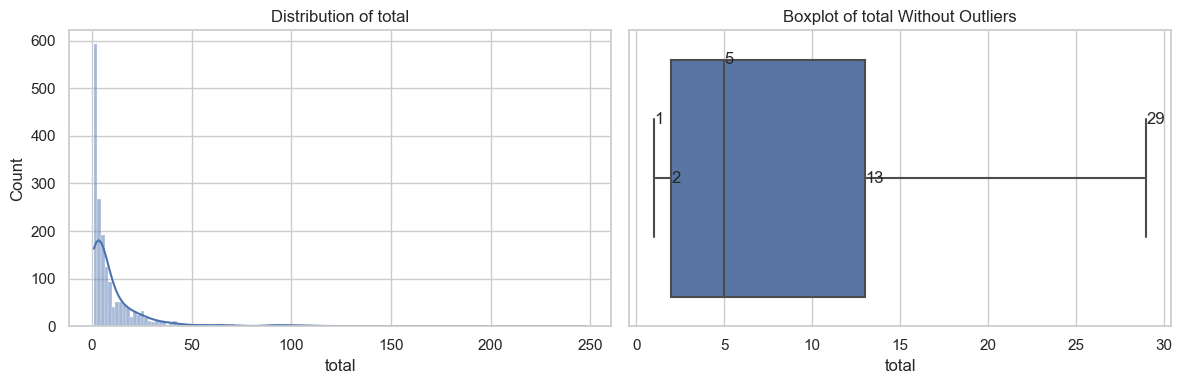

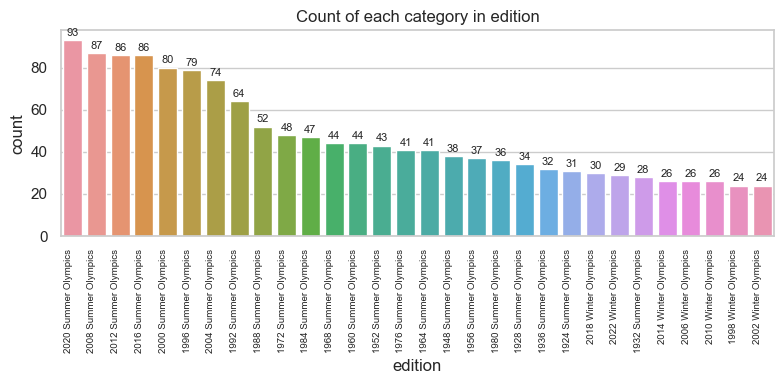

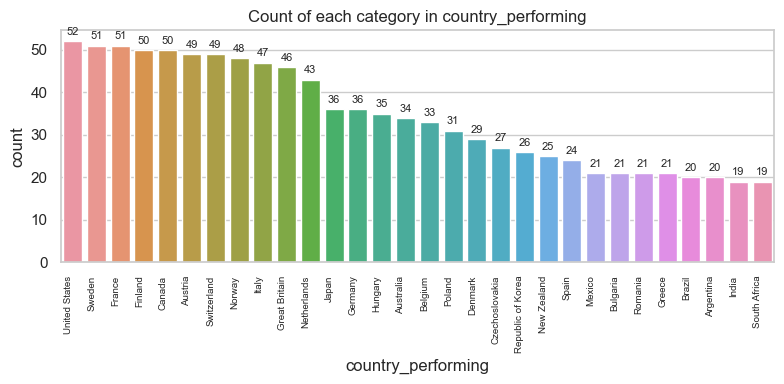

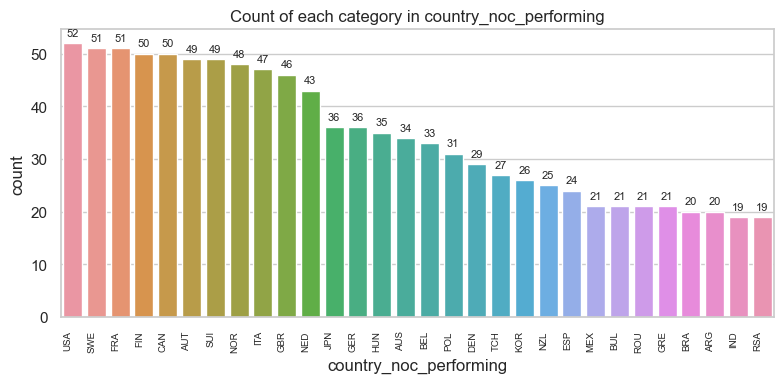

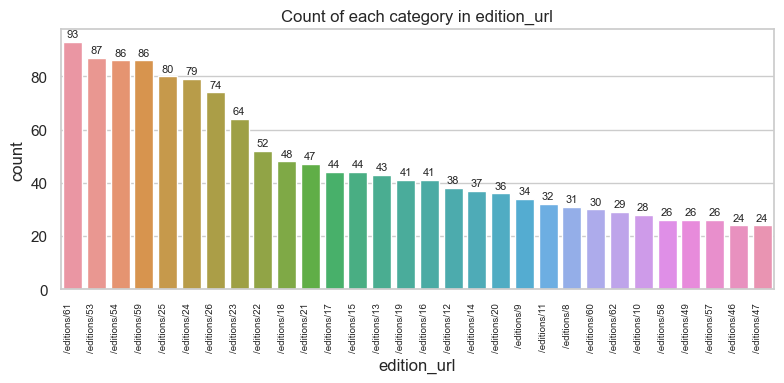

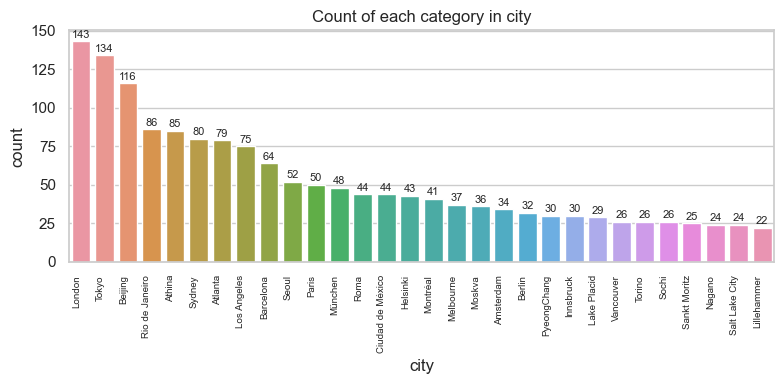

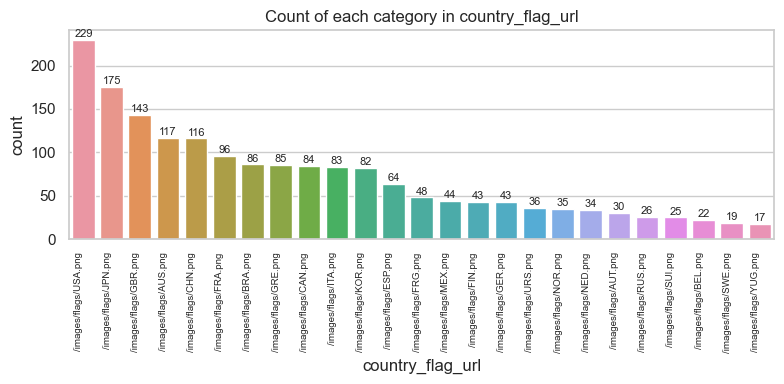

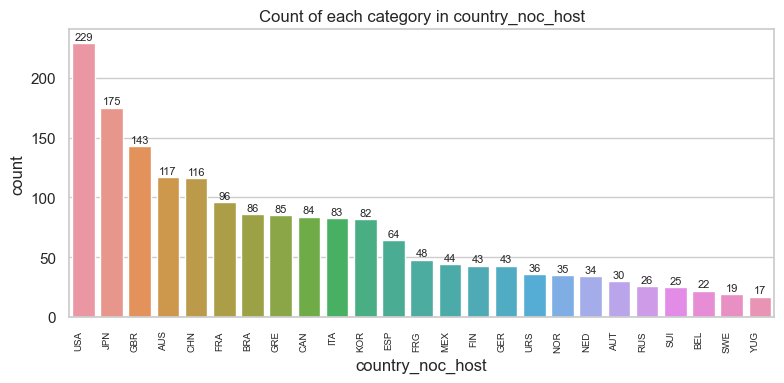

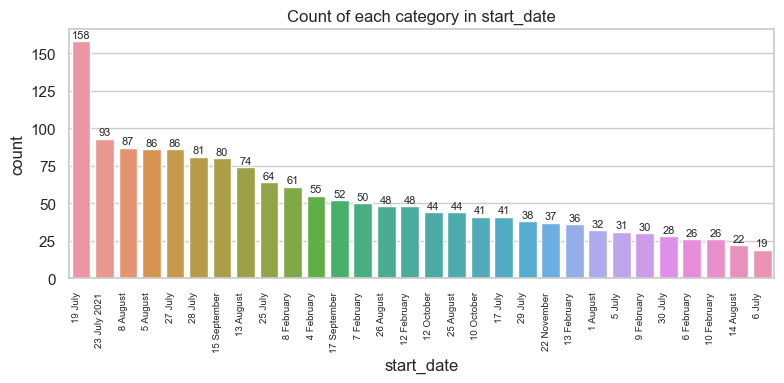

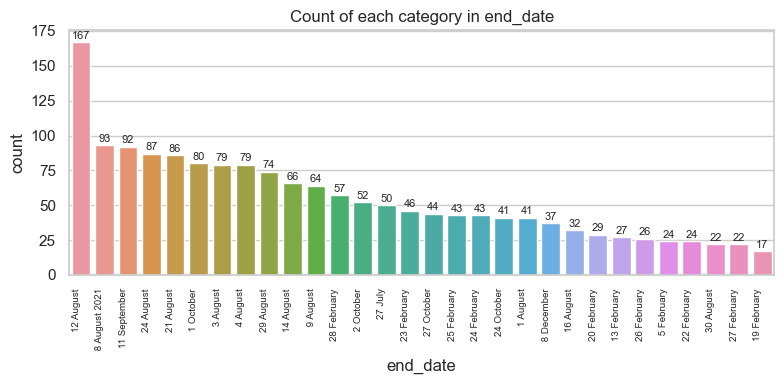

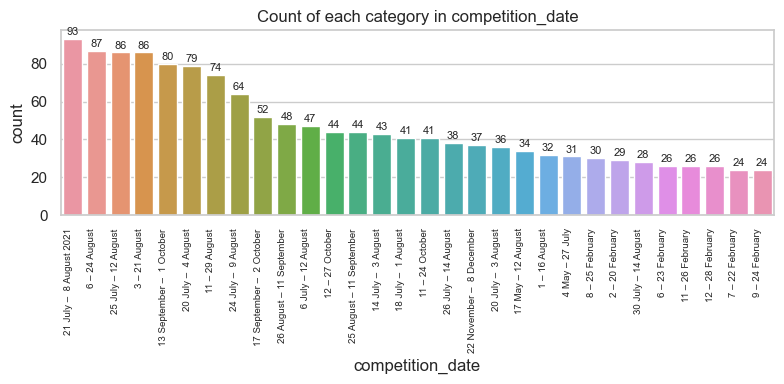

No categories to show for column isHeld.


<Figure size 800x400 with 0 Axes>

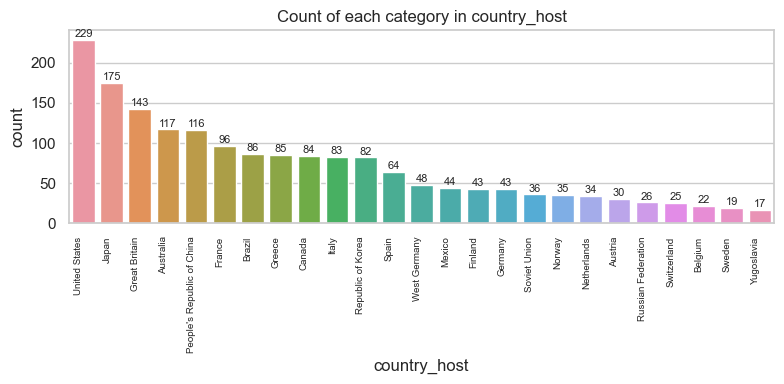

In [651]:
eda_visualization(df_games_medals)

In [652]:
#further analyze df_games_medals 
df_comparison = df_games_medals.groupby(['country_host', 'edition', 'year', 'country_performing'], as_index=False)[['total', 'gold', 'silver', 'bronze']].sum() \
    .groupby('edition', group_keys=False) \
    .apply(lambda x: x.nlargest(8,'total'))

In [653]:
#add dummy variabe for season
df_comparison['season'] = [1 if 'Winter' in edition else 0 for edition in df_comparison['edition']]

In [654]:
sns.scatterplot(y='total', x='mean_pop_last_10yr_mm', data=df_filtered, color='salmon')#add another dummy variable for is_host

df_comparison['is_host'] = np.where(df_comparison['country_host'] == df_comparison['country_performing'], 1, 0)

In [655]:
df_summer = df_comparison[df_comparison['season'] == 0]
df_summer2 = df_summer.groupby(['year', 'is_host'])['total'].sum()
df_summer2 = pd.DataFrame(df_summer2)
df_summer2.reset_index(inplace=True)

<div style="background-color: #FFFFE0; border: 2px solid #FFD700; padding: 20px;">
<strong><i>Does being a host country appear to furnish an advantage?</i></strong>
<br>
For most years, the host country wins medals. The number of medals won by the host country appears to be more sizable during the summer games than the winter ones. Though some countries are repeatedly hosting the games and could simply be strong contenders, it is likely still an influential factor. We will include is_host and season as two binary variables to capture this potential effect. 
</div>

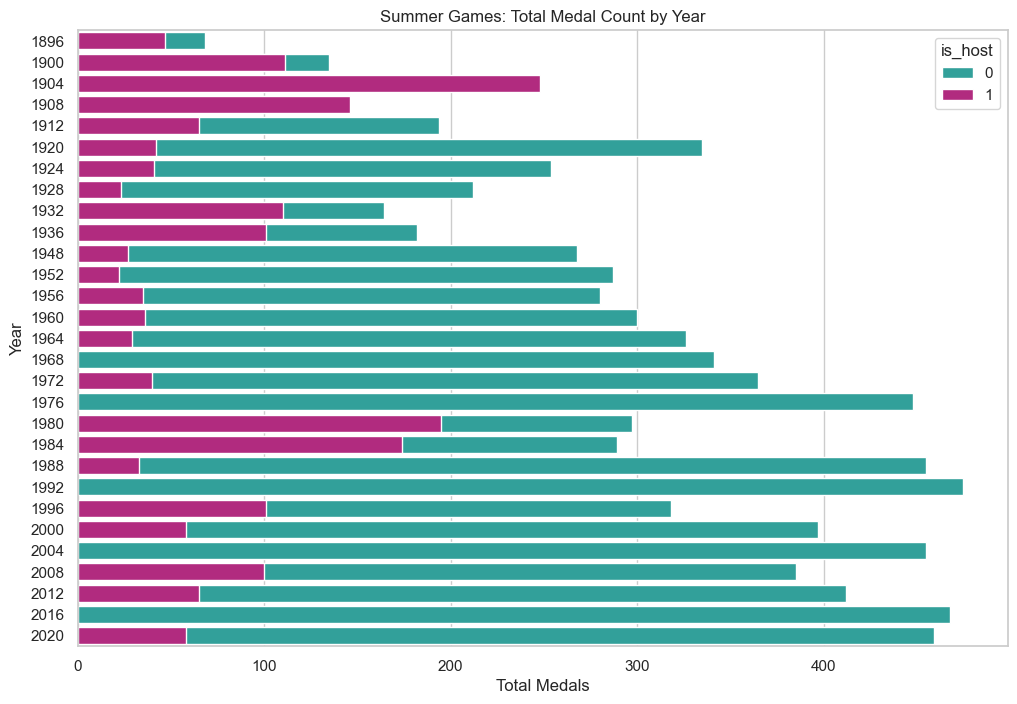

In [657]:
#plot summer games
plt.figure(figsize=(12, 8))
sns.barplot(x='total', y='year', hue='is_host', data=df_summer2, dodge=False, ci=None,palette={1: 'mediumvioletred', 0: 'lightseagreen'}, orient='h')
plt.title('Summer Games: Total Medal Count by Year')
plt.xlabel('Total Medals')
plt.ylabel('Year')
plt.show()

In [658]:
#plot winter games

df_winter = df_comparison[df_comparison['season'] == 1]
df_winter2 = df_winter.groupby(['year', 'is_host'])['total'].sum()
df_winter2 = pd.DataFrame(df_winter2)
df_winter2.reset_index(inplace=True)
df_winter2.head()

,year,is_host,total
0,1924,0,44
1,1924,1,3
2,1928,0,37
3,1932,0,28
4,1932,1,12


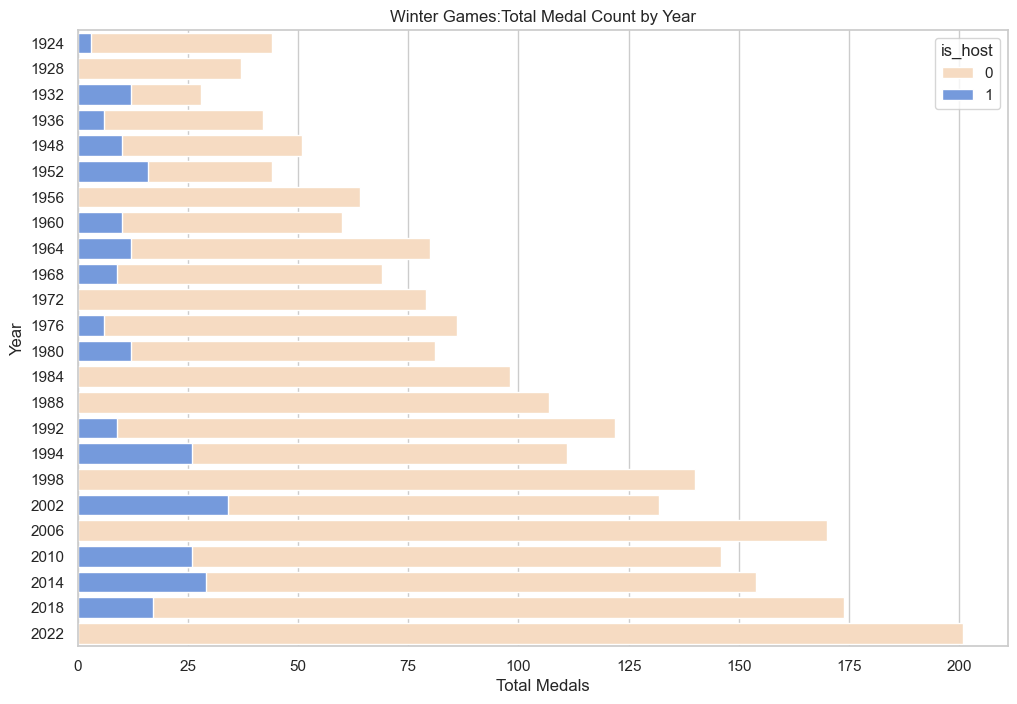

In [659]:

plt.figure(figsize=(12, 8))
sns.barplot(x='total', y='year', hue='is_host', data=df_winter2, dodge=False, ci=None,palette={1: 'cornflowerblue', 0: 'peachpuff'}, orient='h')
plt.title('Winter Games:Total Medal Count by Year')
plt.xlabel('Total Medals')
plt.ylabel('Year')
plt.show()

<strong> Start building model:</strong>

We will now build a baseline model to predict how many medals a country will win at the Olympics.

In [662]:
#function toplot residuals 
def plot_residuals(actual_values, predicted_values, title='Residual Plot'):  
    sns.set_style('darkgrid')
    residuals = actual_values - predicted_values

    plt.figure(figsize=(5, 3))
    sns.scatterplot(x=actual_values, y=residuals, color='lightblue')
    plt.axhline(y=0, color='red', linestyle='--')

    plt.title(f'{title}', fontsize=12)
    plt.xlabel('Actual Values', fontsize=10)
    plt.ylabel('Residuals', fontsize=10)
    plt.grid(True)
    plt.show()

In [663]:
results = []

In [664]:
def record_results(model):
    global results
    results.append({
        'model':f'{model}',
        'MSE train': f'{mse_train}',
        'MSE test': f'{mse_test}',
        'RMSE train': f'{np.sqrt(mse_train)}',
        'RMSE test': f'{np.sqrt(mse_test)}',
        'R2 train': f'{r2_score(y_train, base_train_predictions)}',
        'R2 test': f'{r2_score(y_test, base_predictions)}'
    })
    print('results recorded')

In [ ]:
#Building a baseline model

#Model 1: Using data for the 2020 Olympics only

#start building df to predict medal count at the 2024 summer games

df_games_medals['is_host'] = np.where(df_games_medals['country_host'] == df_games_medals['country_performing'], 1, 0)

#add gdp and population-using already processed df saved in the data folder

df_gdp_pop = pd.merge(df_gdp_mean,df_pop_mean, on='country_noc', how='left')
df_gdp_pop.drop(['country_x', 'Country Code_x', 'country_y', 'Country Code_y'], axis=1, inplace=True)

In [ ]:
#cols for model
df_cols = df_games_medals[['year','edition', 'country_noc_performing', 'gold', 'silver', 'bronze','total', 'is_host']]

In [ ]:
df_cols.rename({'country_noc_performing':'country_noc'}, axis=1, inplace=True)
df_cols.head()

In [ ]:
#merge
df_model = pd.merge(df_cols, df_gdp_pop[['country_noc','mean_gdp_last_10yr_bn', 'mean_pop_last_10yr_mm']], on='country_noc', how='left')


In [ ]:
#add contingent size 
contingent_size = df_event_results.groupby(['edition', 'country_noc'], as_index=False)['athlete'].nunique()

df_model2 = pd.merge(df_model, contingent_size[['edition','country_noc','athlete']], on=['edition','country_noc'], how='left')
df_model2.head()

In [ ]:
df_model2.rename({'athlete':'contingent_size'}, axis=1,inplace=True)

In [ ]:
#number of events they participate in

event_participation =  df_event_results.groupby(['edition', 'country_noc'], 
                                                                 as_index=False)['event'].nunique()

df_model3 = pd.merge(df_model2, event_participation[['edition','country_noc','event']], on=['edition','country_noc'], how='left')
df_model3.rename({'event':'event_count'}, axis=1, inplace=True)
df_model3.head()

In [ ]:
#has country won medals in the past

prior_medals = pd.DataFrame(df_medals.groupby('country_noc')['total'].sum())
prior_medals.reset_index(inplace=True)
prior_medals.head()

In [ ]:
#add dummy
prior_medals['prior_medals'] = (prior_medals['total'] > 0).astype(int)

In [ ]:
prior_medals.head()

In [ ]:
#using 2020 data only
df_2020 = df_model3.loc[df_model3['year']==2020]

In [ ]:
df_2020.drop(['year', 'edition', 'gold', 'silver', 'bronze'], axis=1, inplace=True)

In [ ]:
#add medals in prior games 

df_medals_2016= df_medals.loc[df_medals['year']==2016]
df_medals_2016.rename({'total':'2016_medals'}, axis=1, inplace=True)

In [ ]:
#merge
df_2020_base = pd.merge(df_2020, df_medals_2016[['country_noc', '2016_medals']], how ='left', on=['country_noc'])
df_2020_base.head()

In [ ]:
df_2020_base['2016_medals'].fillna(0, inplace=True)

In [ ]:
df_2020_base.dropna(inplace=True)

In [ ]:
df_2020_base.rename({'total':'total_medals'}, axis=1, inplace=True)

In [ ]:
df_2020_base = pd.merge(df_2020_base, prior_medals[['country_noc', 'prior_medals']], 
                        on='country_noc', how='left')

In [ ]:
#run a basic linear reg model
X = df_2020_base[['is_host', 'mean_gdp_last_10yr_bn', 'mean_pop_last_10yr_mm', 'contingent_size',
            'event_count', '2016_medals', 'prior_medals']]
y = df_2020_base['total_medals']

X_train, X_test, y_train, y_test = train_test_split( 
    X, y, test_size=0.25, random_state=101) 

In [ ]:
base_model = LinearRegression()
base_model.fit(X_train, y_train)
base_predictions = base_model.predict(X_test)

In [ ]:
mse_test = mean_squared_error(y_test, base_predictions)
print(mse_test)

In [ ]:
base_train_predictions = base_model.predict(X_train)
mse_train = mean_squared_error(y_train, base_train_predictions)
print(mse_train)

In [ ]:
#add predictions to df 
df_2020_base['predicted_total_medals'] = base_model.predict(X)
df_2020_base.head()

In [ ]:
coefficients = base_model.coef_

# coefficients with their corresponding feature names
coef_df = pd.DataFrame({'Feature': X.columns, 'Coefficient': coefficients})

print(coef_df)

In [ ]:
plot_residuals(y_test, base_predictions, title='Residual Plot Base 2020 LR Model')

In [ ]:
record_results(model='Base 2020 LR')

In [ ]:
#Model 2- exlcuding USA, just testing if there is any improvement


df_2020_wo_usa = df_2020_base.loc[df_2020_base['country_noc']!= 'USA']

X = df_2020_wo_usa[['is_host', 'mean_gdp_last_10yr_bn', 'mean_pop_last_10yr_mm', 'contingent_size',
            'event_count', '2016_medals', 'prior_medals']]
y = df_2020_wo_usa['total_medals']

X_train, X_test, y_train, y_test = train_test_split( 
    X, y, test_size=0.25, random_state=101) 

In [ ]:
base_model = LinearRegression()
base_model.fit(X_train, y_train)
base_predictions = base_model.predict(X_test)

In [ ]:
mse_test = mean_squared_error(y_test, base_predictions)
print(mse_test)

In [ ]:
base_train_predictions = base_model.predict(X_train)
mse_train = mean_squared_error(y_train, base_train_predictions)
print(mse_train)

In [ ]:
plot_residuals(y_test, base_predictions, title='Residual Plot Base 2020 LR Model')

In [ ]:
record_results(model='Base 2020 LR no USA')

In [ ]:
coefficients = base_model.coef_

# coefficients with their corresponding feature names
coef_df = pd.DataFrame({'Feature': X.columns, 'Coefficient': coefficients})

print(coef_df)

In [ ]:
# Model 3: Trying with all the years instead of just 2020

In [ ]:
# adding the season dummy 
df_model3['winter'] = [1 if 'Winter' in edition else 0 for edition in df_model3['edition']]

In [ ]:
# merging 
df_model3 = df_model3.merge(prior_medals[['country_noc', 'prior_medals']], on='country_noc')

In [ ]:
df_model3['previous_year_medals']=df_model3.groupby(['country_noc','winter'])['total'].shift()

In [ ]:
df_model3['previous_year_medals'].fillna(0, inplace=True)

In [ ]:
df_model3.drop(['edition', 'gold', 'silver', 'bronze'], axis=1, inplace=True)

In [ ]:
df_model3[df_model3.isna().any(axis=1)]

In [ ]:
df_model3.dropna(inplace=True)

In [ ]:
df_model3.head()

In [ ]:
mean_total_up_to_date = df_model3.groupby(['country_noc', 'winter'], as_index=False)['total'].rolling(window=3,  closed= "left").mean()
mean_total_up_to_date = mean_total_up_to_date.rename(columns={'total':'3_lags_mean'})

In [ ]:
df_model3 = pd.concat([df_model3, mean_total_up_to_date['3_lags_mean']], axis=1)

In [ ]:
df_model3.head()

In [ ]:
X = df_model3[['year','is_host', 'mean_gdp_last_10yr_bn', 'mean_pop_last_10yr_mm', 'contingent_size',
            'event_count', 'previous_year_medals', 'prior_medals',
              'winter']]

y = df_model3['total']

X_train, X_test, y_train, y_test = train_test_split( 
    X, y, test_size=0.25, random_state=101, stratify=df_model3['year']) 

In [ ]:
base_model.fit(X_train, y_train)
base_predictions = base_model.predict(X_test)

In [ ]:
mse_test = mean_squared_error(y_test, base_predictions)
print(np.sqrt(mse_test), mse_test) 

In [ ]:
base_train_predictions = base_model.predict(X_train)
mse_train = mean_squared_error(y_train, base_train_predictions)
print(np.sqrt(mse_train), mse_train) 

In [ ]:
coefficients = base_model.coef_

# coefficients with their corresponding feature names
coef_df = pd.DataFrame({'Feature': X.columns, 'Coefficient': coefficients})

coef_df

In [ ]:
plot_residuals(y_test, base_predictions, title='Residual Plot Test All Years Model')
plot_residuals(y_train, base_train_predictions)

In [ ]:
record_results(model='Base all years LR')

In [ ]:
pd.DataFrame(results).T

<strong> Evaluation </strong>

<div style="background-color: #FFFFE0; border: 2px solid #FFD700; padding: 20px;">
The base LR model using 2020 data performs best in terms of MSE, especially when dropping the US as a country. The magnitude of the errors is lower, and the number of medals predicted go from being off by 6.5 to 6.3 (decimals are a result of using a linear regression model on count data). However, the difference between the train and test MSEs in the second fitting that drops the USA is larger. Since such a significant outlier was removed, the model is perhaps overfitting on noise that it can now better perceive. Some collinearity between variables like contingent size and event count, prior medals and previous year medals, etc. could also contribute. The R2 for the fitting without the USA is lower than that of the first, possibly because removing a row of data in a small dataset can cause information loss that affects the overall goodness of fit. Meanwhile, the base model applied to all years performs the worst, with a larger difference in train-test scores and generally worse metrics. 

Considering that the assumptions of linear regression are violated (e.g. heteroscedasticity, independence of observations, possible collinearity, etc.), this base model performs well. Going forward, it will be important to address the time component of the data (whether it means focusing on a smaller dataset or using all years) and the treatment of outliers like the USA (e.g., taking the log may improve the model). Moreover, since the model performs well initially, the possibilty of information leakage exists; the model may be capable of inferring a certain year's medal count based on the medal counts available for that year in the training data. 

Data size is another aspect: if only one year is used, the data shrinks to around 80 rows, which is not a robust number. We may need to explore data generation/oversampling techniques, or find a time-series appropriate solution that allows the use of more years. In terms of modelling, we look forward to exploring methods for count data, such as random forest, gradient boosting, poisson regression, etc. 

This base model furnishes a first glimpse of the feature importances. Being a host increases the medal tally by 1.5, all things equal, while winter seems to decrease it by 1.1. Previous year medals and contingent size also have a somewhat smaller, positive contribution. Applied to 2020 data, the important features become the number of events partaken in. Interestingly, the sign switches for 2016_medals after removing the USA; they are decreasing the the medals won by a country in 2020. We are currently working on adding more variables, for example related to climate, pollution, distance to the host country, etc. These are country inherent characteristics that are likely to impact the performance of athletes and in turn, the total medals. 
    </div>

<strong>Ongoing Work:</strong>

We are going to add additional data elements like Greenhouse emissions, incentives for winning a medal, temperature to see if they improve the predictive power of the models.

In [ ]:
# add pollution variable (greenhouse gas emissions) 
ghg_df = pd.read_excel('data/raw/GHG.xlsx', sheet_name='GHG_per_capita_by_country')

In [ ]:
ghg_df.drop(columns=['EDGAR Country Code','Country'], inplace=True)

In [ ]:
ghg_df = ghg_df[ghg_df['country_noc'].notna()]

In [ ]:
ghg_df = pd.melt(ghg_df, id_vars=['country_noc'], var_name='year', value_name='ghg_per_capita')

In [ ]:
ghg_df['year'] = ghg_df['year'].astype(int)
ghg_df.head()

In [ ]:
#bring in temperature data
temp_df = pd.read_csv('data/raw/temperature.csv')
temp_df.head()

In [ ]:
#bring in olympic incentives
incentives_df = pd.read_csv('data/raw/medal_incentives.csv')
incentives_df.rename({'Gold': 'incentive_gold'}, axis=1, inplace=True)
incentives_df.head()

In [ ]:
#melting gdp 

df_country3 = df_country2.drop(['country', 'Country Name', 'Country Code', 'mean_gdp_last_10yr_bn'], axis=1)
df_country3 = pd.melt(df_country3, id_vars=['country_noc'], var_name='year', value_name='gdp')
df_country3.head()

In [ ]:
# countries with missing data we can still add (that arent nonsensical):
# eri, gam, gbs, gdr, cub, kgz, lao, lbn, lca, bhu, afg, asa, bah, cgo, civ, cod,mda, tga, tkm, tur, ven,tan, 
# yem,syr, scg

In [ ]:
df_country3.year = df_country3.year.astype(int)

In [ ]:
#melt population

df_pop3 = df_pop2.drop(['country', 'Country_Updated', 'Country Code', 'mean_pop_last_10yr_mm'], axis=1)
df_pop3 = pd.melt(df_pop3, id_vars=['country_noc'], var_name='year', value_name='population')
df_pop3.head()

In [ ]:
df_pop3.year = df_pop3.year.astype(int)

In [ ]:
df_model3 = df_model3.fillna(0)

In [ ]:
## merge with df_model3

df_model4 = pd.merge(df_model3, incentives_df[['country_noc', 'offers_incentive', 'incentive_gold']], 
                          on='country_noc', how='left')

df_model4.offers_incentive = df_model4.offers_incentive.fillna(0)
df_model4.incentive_gold = df_model4.incentive_gold.fillna(0)

In [ ]:
df_model4.offers_incentive = df_model4.offers_incentive.map({'Yes': 1, 'No': 0})
df_model4.offers_incentive = df_model4.offers_incentive.fillna(0)

In [ ]:
#now merge temp

df_model4 = pd.merge(df_model4, temp_df[['country_noc','avg_temp']], on='country_noc', how='left')

In [ ]:
df_model4.avg_temp = df_model4.avg_temp.fillna(0)

In [ ]:
#impute mean for missing temp values 
mean_temp = df_model4['avg_temp'].mean()
df_model4['avg_temp'].fillna(mean_temp, inplace=True)

In [ ]:
#merge with emissions

df_model4 = pd.merge(df_model4, ghg_df[['country_noc', 'year', 'ghg_per_capita'
                                     ]], on=['country_noc', 'year'], how='left')

In [ ]:
df_model4.dropna(subset=['ghg_per_capita', 'mean_pop_last_10yr_mm','mean_gdp_last_10yr_bn'], inplace=True)


In [ ]:
#drop mean gdp and pop
df_model4.drop(['mean_pop_last_10yr_mm', 'mean_gdp_last_10yr_bn'], axis=1, inplace=True)

In [ ]:
#merge with gdp data
 
df_model4 = pd.merge(df_model4, df_country3[['country_noc', 'year', 'gdp']], on=['country_noc', 'year'], 
                     how='left')
df_model4.head()

In [ ]:
df_model4 = pd.merge(df_model4, df_pop3[['country_noc', 'year', 'population']], on=['country_noc', 'year'], 
                     how='left')
df_model4.head()

In [ ]:
df_model4[df_model4['gdp'].isna()]

In [ ]:
df_model4.loc[(df_model4['year']==1972)&(df_model4['country_noc']=='HUN'), 'gdp'] = 50.47

In [ ]:
def impute_gdp(year,country,amount):
    df_model4.loc[(df_model4['year']==year)&(df_model4['country_noc']==country), 'gdp'] = amount

In [ ]:
impute_gdp(1976,'HUN',62.79)

In [ ]:
impute_gdp(1980,'HUN',72.65)

In [ ]:
impute_gdp(1988,'HUN',85.52)

In [ ]:
impute_gdp(1972,'SUI',352.92)

In [ ]:
impute_gdp(1976,'SUI',337.30)

In [ ]:
impute_gdp(1992,'EST',10.94)

In [ ]:
impute_gdp(1972,'POL',142.47)

In [ ]:
impute_gdp(1976,'POL',181.78)

In [ ]:
impute_gdp(1980,'POL',200.28)

In [ ]:
impute_gdp(1988,'POL',219.61)

In [ ]:
impute_gdp(1972,'ROU',54.80)

In [ ]:
impute_gdp(1976,'ROU',83.30)

In [ ]:
impute_gdp(1980,'ROU',107.42)

In [ ]:
impute_gdp(1984,'ROU',125.62)

In [ ]:
impute_gdp(1992,'LAT',14.86)

In [ ]:
impute_gdp(1992,'IRI',217.62)

In [ ]:
impute_gdp(1972,'LBN',19.54)

In [ ]:
impute_gdp(1980,'LBN',12.63)

In [ ]:
impute_gdp(1972,'BUL',21.56) # will actually have to impute, got it from croatia

In [ ]:
impute_gdp(1976,'BUL',23.91) # will actually have to impute, got it from croatia

In [ ]:
impute_gdp(2016,'VEN',423.21) 

In [ ]:
impute_gdp(2020,'VEN',157.59) 

In [ ]:
impute_gdp(1972,'ETH',5.94) # will actually have to impute, got it from cameroon

In [ ]:
impute_gdp(1980,'ETH',10.92) # will actually have to impute, got it from cameroon

In [ ]:
impute_gdp(1972,'MGL',1.43) 

In [ ]:
impute_gdp(1976,'MGL',1.80) 

In [ ]:
impute_gdp(1980,'MGL',2.32) 

In [ ]:
impute_gdp(1992,'LTU',23.39) 

In [ ]:
impute_gdp(1992,'ISR',125.94) 

In [ ]:
impute_gdp(1992,'SLO',23.42) 

In [ ]:
impute_gdp(1994,'SLO',25.37) 

In [ ]:
impute_gdp(1992,'CRO',29.68) 

In [ ]:
df_model4.drop(['prior_medals'], axis=1, inplace=True)

In [ ]:
df_model4_corr = df_model4.drop(columns=['country_noc'])
correlation_matrix = df_model4_corr.corr()

#plot
plt.figure(figsize=(10, 8))
sns.set(style="white")
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=.5)
plt.show()

<div style="background-color: #007bff; padding: 15px; border-radius: 10px; color: #ffffff;">
    <h2>Time Series Data: Strategy, Test/Train Splitting and Cross Fold Validation</h2>
</div>

<div style="background-color: #E6F7FF; border-radius: 10px; border: 2px solid #007bff; padding: 10px;">
    <p> Time series modelling is an extensive field and goes beyond the scope of this course. However, without accounting for the time components in our data, our models will not approximate reality. Our strategy is therefore to turn this time series problem into a supervised learning one by incorporating time features that account for the correlations to prior periods. 
<br><br>To begin, we must create train and test sets. Splitting the data into train and test sets considers more caution for time series problems. 
        The baseline linear regression model was leaking data from the train set into the test set, as splitting had been done using the tradional 80/20 train/test split implementation from Scikit Learn. Information from the year of prediction was in the train set, meaning information about the Olympic Games at the time of prediction that would normally be impossible to know (since the event hasn't occured) was used. Consequently, the baseline model's good performance came from overfitting, especially considering that none of the assumptions of linear regression were met. 
To mitigate this effect, we considered 3 time series splitting techniques:<li> Rolling window: using a T (time of prediction)-1 train set to predict T (validation data). The data is split into several folds of T-1 training data and T validation data.
    <li>Expanding/Rolling window: starting with T (time of prediction)-1 as the train set and using the previous year's validation data (T) as the train once the next prediction period (T+1) arrives. The train set for that new prediction period T+1 not just include T-1, but also T-2. The train set grows cumulatively with every fold, until T-n. </li></p>
    We chose to use an expanding window due to a limited validation set size (x=1032), meaning only 200 observations per fold if split evenly. Moreover, historical occurences may have impact on future medal count, and it is useful to see how the model performs when predicting year-on-year in the first fold, as opposed to year-on-past in the last fold. 
<br><br> In addition, cross validation is different for time series as the test set should be kept out of the train for that given year. Sectioning the data into equally sized blocks does not work. Instead, we will compare the performance for each validation fold. Since each fold is trained on a different number of years, it provides a good cross validation benchmark.
</div>

## Test Split: Year 2022 

In [ ]:
# It is good practice to set the year as index for time series data
# Scikit Learn's time series splitting method also requires it to be so
df_model4.set_index('year', inplace=True)

In [ ]:
df_model4.sort_index(inplace=True)

In [ ]:
# Converting to datetime format
df_model4.index = pd.to_datetime(df_model4.index, format='%Y')

In [ ]:
# Setting the year column as the index
df_model4['year'] = df_model4.index

In [ ]:
# Keeping the year column
df_model4['year'] = df_model4['year'].dt.year

<div style="background-color: #FFFFE0; border: 2px solid #FFD700; padding: 20px;">
    <li> The test (untouched) data to assess final performance is from year 2022.</li>
    <li> Everything before 2022 is part of the training set, which is further split into train and validation using the strategy detailed above.</li>

            
</div>

In [ ]:
features= df_model4.drop(columns=['total', 'country_noc']).columns

X_val = df_model4[df_model4.index<'2022'][features]
y_val = df_model4[df_model4.index<'2022']['total']

X_test_ = df_model4[df_model4.index=='2022'][features]
y_test_ = df_model4[df_model4.index=='2022']['total']

## Available Tools: Scikit Learn TimeSeriesSplit()

In [ ]:
n_splits=9 # We tried several numbers

In [ ]:
# Instantiating the splitter. The gap parameter dictates the interval between the last train data and test data.
# It had to be increased for reasons explained below
tscv = TimeSeriesSplit(n_splits=n_splits, gap=45) 

### 1. Resulting Folds & Splits

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))


for i, (train_index, test_index) in enumerate(tscv.split(X_val)):
    train_bar = ax.barh(i, len(train_index), color='blue', label=f'Iteration {i + 1} (Train)')
    test_bar = ax.barh(i, len(test_index), left=len(train_index), color='orange', label=f'Iteration {i + 1} (Test)')
    

legend_labels = ['Train', 'Test']
ax.legend(labels=legend_labels)

ax.set_yticks(np.arange(n_splits))
ax.set_yticklabels([f'Iteration {i+1}' for i in range(n_splits)])
ax.set_ylabel('Iteration')
ax.set_xlabel('Index Count')
plt.title('Train/Test Index for Each Train/Test Split by Iteration')

plt.show()

<div style="background-color: #FFFFE0; border: 2px solid #FFD700; padding: 20px;">
    The graph above demonstrates that the expanding window technique worked correctly. The first iteration even has more test data than train, whereas the last fold's training data is a cumulative collection of all years prior. The test set continuously remains the same size, which introduces an issue: the number of points in our data varies between the years. Not every country participates each year, meaning a 1:1 match is not possible. As time series data is dependent on previous observations, this impacts the model and will be addressed later in the notebook. 
    
</div>

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
legend_handles=[]

for i, (train_index, test_index) in enumerate(tscv.split(X_val)):
    train_points = ax.scatter([i] * len(train_index), X_val.index[train_index], label=f'Iteration {i + 1} (Train)', color='blue', marker='s', s=50)
    test_points = ax.scatter([i] * len(test_index), X_val.index[test_index], label=f'Iteration {i + 1} (Test)', color='orange', marker='s', s=50)

    # do we have dates that are passing into both train and test?
    common_points = set(X_val.index[train_index]) & set(X_val.index[test_index])
    if common_points:
        ax.scatter([i] * len(common_points), list(common_points), color='red', marker='o', s=50)


legend_handles = [
    plt.Line2D([0], [0], marker='s', color='w', markerfacecolor='blue', markersize=10, label='Train'),
    plt.Line2D([0], [0], marker='s', color='w', markerfacecolor='orange', markersize=10, label='Test'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Overlapping Dates in Train and Test')
]

ax.legend(handles=legend_handles)


ax.set_xticks(np.arange(n_splits))
ax.set_xticklabels([f'Iteration {i+1}' for i in range(n_splits)]) 
ax.set_xlabel('Iteration')
ax.set_ylabel('Date')
plt.title('Train/Test Split for Each Iteration: Years Used in Split')

plt.show()

<div style="background-color: #FFFFE0; border: 2px solid #FFD700; padding: 20px;">
    The time series splitting that Scikit Learn does not cater to data of differing observation numbers. Though we attempted to remove any overlapping train and validation data through the gap parameter, this resulted in data loss (45 observations in this example) and overlaps that persisted in iterations 3 and 4. As seen in the baseline model, this is data leakage. Therefore, we implement the expanding window ourselves below.
    
</div>

In [ ]:
# We lose data points: see below
# Out of 1032 observations, we only use 987 (45 points lost, which is the gap number)
X_val.shape[0]

In [ ]:
# There has to be a big gap as a parameter if we dont want train data year in the test but that leads to data loss

for i, (train_index, test_index) in enumerate(tscv.split(X_val)):
    print(f'Train size: {X_val.index[train_index].shape[0]}')
    print(f'Test size: {X_val.index[test_index].shape[0]}')
    print(f'Train newest date: {X_val.index[train_index].max()}')
    print(f'Test oldest date: {X_val.index[test_index].min()}')
    print('---------------------')

### 2. Performance

In [ ]:
# How does it perform?
mse_values = []
model_summaries = [] 

for i, (train_index, test_index) in enumerate(tscv.split(X_val)):
    X_train, X_test = X_val.iloc[train_index, :], X_val.iloc[test_index, :]
    y_train, y_test = y_val.iloc[train_index], y_val.iloc[test_index]
        
    X_train = sm.add_constant(X_train) 
    model = sm.OLS(y_train, X_train).fit()

    X_test = sm.add_constant(X_test) 
    y_pred = model.predict(X_test)
    y_pred_train = model.predict(X_train)

    mse = np.mean((y_test - y_pred)**2)
    rmse = mse**0.5
    
    mse_train = np.mean((y_train - y_pred_train)**2)
    rmse_train = mse_train**0.5

    model_summaries.append(model.summary())

    print(f'Iteration {i + 1} - MSE: {mse:.4f} - RMSE: {rmse:.4f} - Train MSE: {mse_train:.4f} - Train RMSE: {rmse_train:.4f}')

In [ ]:
model_summaries[8]

<div style="background-color: #FFFFE0; border: 2px solid #FFD700; padding: 20px;">
    The performance is good with a high R-squared of 0.864 and a low average MSE (the RMSE indicates the model is only 3.6 medals off at one point). However, the splitting will cause overfitting and therefore can't be used.
    
</div>

<div style="background-color: #007bff; padding: 15px; border-radius: 10px; color: #ffffff;">
    <h2>Splitting Implementation & Fitting a Linear Regression</h2>
</div>

<div style="background-color: #E6F7FF; border-radius: 10px; border: 2px solid #007bff; padding: 10px;">
    We start by determining a strategy that allows us to manually implement the expanding window. We assess the performance with linear regression and identify next steps.

In [ ]:
dates = X_val.index.unique()

In [ ]:
# Every 4th date is the validation set
dates

<div style="background-color: #FFFFE0; border: 2px solid #FFD700; padding: 20px;">
    Implementing the expanding window is not straightforward as the time between the games are not constant. A T-1 game could be 2 years ago, but also 4 or another number. Therefore we use the unique date values from our data's index and work with indices instead. 
    <li> Given that there are 20 unique years, every 4th in the sequence will be the validation set. 

</div>

In [ ]:
c = 1 # Used as a counter for annotating the graph
mses = []
mses_train = []
rmses = []
rmses_train = []

plt.figure(figsize=(12, 7))
plt.scatter(y_val.index, y_val, label='Actual', color='blue', marker='o', s=20)
plt.title('Actual vs Predicted Values for All Iterations')
plt.xlabel('Date')
plt.ylabel('Total Medals')
plt.legend()

for i in range(3, 20, 4): # Starting at the fourth (third index) year, until the last, in steps of 4 
    # Define the splits by index
    X_train = X_val[X_val.index.isin(dates[:i])]
    X_test = X_val[X_val.index.isin([dates[i]])]
    y_train = y_val[y_val.index.isin(dates[:i])]
    y_test = y_val[y_val.index.isin([dates[i]])]
    
    # Then fit the linear regression
    X_train = sm.add_constant(X_train) 
    X_test['const'] = 1 # Had to add this manually because add_constant was not working on X_test.
    position = 0  
    X_test.insert(position, 'const', X_test.pop('const')) # Inserting into front of dataframe
    model = sm.OLS(y_train, X_train).fit()
    
    y_pred = model.predict(X_test)
    y_pred_train = model.predict(X_train)

    mse = np.mean((y_test - y_pred)**2)
    rmse = mse**0.5
    
    mse_train = np.mean((y_train - y_pred_train)**2)
    rmse_train = mse_train**0.5
    
    mses.append(mse)
    mses_train.append(mse_train)
    rmses.append(rmse)
    rmses_train.append(rmse_train)
    
    plt.scatter(X_test.index, y_pred, label=f'Predicted - Iteration {i}', marker='o', s=20, color='orange')
    
    
    print(f'Iteration {i + 1} - MSE: {mse:.4f} - RMSE: {rmse:.4f} - MSE train: {mse_train:.4f} - RMSE train: {rmse_train:.4f}')


<div style="background-color: #FFFFE0; border: 2px solid #FFD700; padding: 20px;">
    A linear regression performs well. Though there are some issues with slightly negative predictions and decimals, the model is off by 6-7 medals on average. The two train years show a predicted point of close to 100 medals, which is no longer there the third time. In the fourth year (first test year), the model then wrongly predicts a similar value around 100. This demonstrates that outliers/values in the tails have a strong impact on predictions. The high value close to 175 medals later causes a large overprediction in the second validation set.
    <br><br>Notably, the first validation set does not perform as well as the others, likely due to limited data. 

</div>

In [ ]:
iterations = list(range(1, len(mses_train) + 1))

# Plotting Train and Test MSEs
plt.figure(figsize=(8, 4))
plt.plot(iterations,mses_train, label='Train MSE', marker='o', color='blue')
plt.plot(iterations, mses, label='Test MSE', marker='o', color='orange')

plt.title('Train and Test Mean Squared Errors over Iterations')
plt.xlabel('Iteration')
plt.ylabel('Mean Squared Error')
plt.xticks(range(1, len(iterations) + 1))

plt.legend()
plt.show()

<div style="background-color: #FFFFE0; border: 2px solid #FFD700; padding: 20px;">
    The error seems to reach a good level from a fold of 3 onwards. That means T-11 periods may be a good amount of training data.

</div>

In [ ]:
model.summary()

<div style="background-color: #FFFFE0; border: 2px solid #FFD700; padding: 20px;">
    The coefficients of the model do not seem useful at this point. Being the host has a very strong effect, all else constant, while the other coefficients have little impact. Looking at the P-values and standard errors, the coefficients are likely not reliable. Considering that the data does not follow the assumptions of linear regression, this is most probable.
</div>

## Examining Residuals 

In [ ]:
plot_residuals(y_test, y_pred, 'Residuals for Linear Regression')

<div style="background-color: #FFFFE0; border: 2px solid #FFD700; padding: 20px;">
    Given the skewed nature of the data, it is unsurprising that the residuals are heteroscedastic. It will be important to address these outliers/tails in order to improve the performance of GLMs. 
</div>

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(model.resid, title='ACF of residual errors')
plt.set_
plt.show()

<div style="background-color: #FFFFE0; border: 2px solid #FFD700; padding: 20px;">
    Autocorrelation is a measure of the correlation between a variable and its lagged (T-n) values. A value close to 1 or -1 indicates high correlation. The first line represents the correlation with the lag itself (T & T). Most of the correlations are dismissably low. However, though minimally, some fall outside the range of comfort. While modelling, reducing the correlations to past values will be imperative in order to successfully frame the time series problem as a supervised learning one.
</div>

<div style="background-color: #007bff; padding: 15px; border-radius: 10px; color: #ffffff;">
    <h2>GLMs: Poisson and Negative Binomial</h2>
</div>

<div style="background-color: #E6F7FF; border-radius: 10px; border: 2px solid #007bff; padding: 10px;">
    This project's data exhibits qualities that are ill-suited to linear regression, such as a right-skewed dependent variable, non-continuous values, heteroscedastic residuals, etc. Our next step is to try a more accomodating GLM. Poisson is a viable alternative as it assumes count data that occurs in fixed time intervals. However, it also requires an equal mean and variance, which will have to be verified. If the variance is greater than the mean (known as overdispersion), negative binomial regression relaxes the assumption and can be used when the data has extra variability. Both models will be tested. 

In [ ]:
def glm_models(modeltype, X_val=X_val, y_val=y_val, graph=True, splits=False):
    '''Packages the previously used validation and plotting code as a function that can use the 3 GLM models. 
    The plotting can be turned off, and splitting the data can be turned on so that only the 5 split data folds 
    are returned. 
    Input: GLM type, validation x and y to be split for cross validation
    Param modeltype: string of either 'Poisson' or 'Neg Binomial', otherwise linear regression will be applied
    Returns: the model, scores, predictions
    '''

    mses = []
    mses_train = []
    rmses = []
    rmses_train = []
    
    if graph:
    
        plt.figure(figsize=(12, 7))
        plt.scatter(y_val.index, y_val, label='Actual', color='blue', marker='o', s=20)
        plt.title(f'Actual vs Predicted Values for All Iterations {modeltype}')
        plt.xlabel('Date')
        plt.ylabel('Total Medals')
        plt.legend()
    
    if splits:
        sets_list=[]
        for i in range(3, 20, 4):
            X_train = X_val[X_val.index.isin(dates[:i])]
            X_test = X_val[X_val.index.isin([dates[i]])]
            y_train = y_val[y_val.index.isin(dates[:i])]
            y_test = y_val[y_val.index.isin([dates[i]])]

            X_train = sm.add_constant(X_train) 
            X_test['const'] = 1 # had to add this manually because add_constant was not working on X_test. No idea why.
            position = 0  
            X_test.insert(position, 'const', X_test.pop('const'))
            sets_list.append([X_train, X_test, y_train, y_test])
        return sets_list
    
    
    for i in range(3, 20, 4):
        X_train = X_val[X_val.index.isin(dates[:i])]
        X_test = X_val[X_val.index.isin([dates[i]])]
        y_train = y_val[y_val.index.isin(dates[:i])]
        y_test = y_val[y_val.index.isin([dates[i]])]

        X_train = sm.add_constant(X_train) 
        X_test['const'] = 1 # had to add this manually because add_constant was not working on X_test. No idea why.
        position = 0  
        X_test.insert(position, 'const', X_test.pop('const'))


        if modeltype == 'Neg Binomial':
            model= sm.GLM(y_train, X_train, family=sm.families.NegativeBinomial()).fit()
            
        elif modeltype == 'Poisson':
            model = sm.GLM(y_train, X_train, family=sm.families.Poisson()).fit()
        
        else:
            model = sm.OLS(y_train, X_train).fit()

        y_pred = model.predict(X_test)
        y_pred_train = model.predict(X_train)

        mse = mean_squared_error(y_test,y_pred)
        rmse = mse**0.5

        mse_train = mean_squared_error(y_train,y_pred_train)
        rmse_train = mse_train**0.5

        mses.append(mse)
        mses_train.append(mse_train)
        rmses.append(rmse)
        rmses_train.append(rmse_train)
        
        if graph:
            plt.scatter(X_test.index, y_pred, label=f'Predicted - Iteration {i}', marker='o', s=20, color='orange')

        print(f'Iteration {i + 1} - MSE: {mse:.4f} - RMSE: {rmse:.4f} - MSE train: {mse_train:.4f} - RMSE train: {rmse_train:.4f}')
        
        
    return model, mses, mses_train, rmses, rmses_train, y_pred, y_pred_train

## Poisson

In [ ]:
model, mses, mses_train, rmses, rmses_train, y_pred, y_pred_train = glm_models('Poisson')

<div style="background-color: #FFFFE0; border: 2px solid #FFD700; padding: 20px;">
    MSE is higher for the Poisson model; it is off by around 10 medals on average (RMSE). The extreme point for the first test year is predicted worse in this model, with an extreme prediction more than 100 medals higher than the actual value. It is likely this comes from assumption of equal mean and variance; as seen in the resiudals, the variance is not constant and will likely fluctuate around the mean a lot. When the data is relatively similar, it predicts accurately.
</div>

In [ ]:
iterations = list(range(1, len(mses_train) + 1))

plt.figure(figsize=(8, 4))
plt.plot(iterations,mses_train, label='Train MSE', marker='o', color='blue')
plt.plot(iterations, mses, label='Test MSE', marker='o', color='orange')

plt.title('Train and Test Mean Squared Errors over Iterations - Poisson Model')
plt.xlabel('Iteration')
plt.ylabel('Mean Squared Error')
plt.xticks(range(1, len(iterations) + 1))

plt.legend()
plt.show()

<div style="background-color: #FFFFE0; border: 2px solid #FFD700; padding: 20px;">
T-15 seems to be a good training time window for this model. That is when the MSE is lowest at around +-5 medals. (RMSE) 
</div>

In [ ]:
model.summary()

<div style="background-color: #FFFFE0; border: 2px solid #FFD700; padding: 20px;">
The coefficients are all very low; some variables have high standard errors in comparison. We do not believe that the equal variance and mean assumption is met. </div>

## Negative Binomial

In [ ]:
sns.set_style('darkgrid')
model, mses, mses_train, rmses, rmses_train, y_pred, y_pred_train = glm_models('Neg Binomial')

<div style="background-color: #FFFFE0; border: 2px solid #FFD700; padding: 20px;">
Overdispersion occurs when the variability in the data is greater than what is expected by the assumed statistical model. However, since the predictions are much worse than the previous models, the cause is unclear. Perhaps if overdispersion is severe, the model might overestimate the uncertainty in predictions, leading to wider prediction intervals and overestimations. Multicollinearity and outliers could also be a cause, yet this would equally manifest in the previous 2 models. 
</div>

In [ ]:
model.summary()

<div style="background-color: #007bff; padding: 15px; border-radius: 10px; color: #ffffff;">
    <h2>Assumptions Check</h2>
</div>

## Homoscedasticity & Skew

In [ ]:
plt.figure(figsize=(12, 6))
plt.hist(df_model4['total'], bins=20, color='lightblue', edgecolor='black')
plt.title('Histogram of Total Medals')
plt.xlabel('Total Values')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(12, 6))
plt.boxplot(df_model4['total'], vert=False, widths=0.7, patch_artist=True, boxprops=dict(facecolor='lightblue'))
plt.title('Boxplot of Total Medals')
plt.xlabel('Total Values')
plt.show()

### 1. Removing Skew: Log Transformation

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Plot the boxplot for np.log(df_model4['total'])
axes[0].hist(np.log(df_model4['total']), bins=20, color='lightblue', edgecolor='black')

axes[0].set_title('Histogram of the Log of Total Medals')

# Plot the boxplot for np.sqrt(df_model4['total'])
axes[1].boxplot(np.log(df_model4['total']), vert=False, widths=0.7, patch_artist=True, boxprops=dict(facecolor='lightblue'))
axes[1].set_title('Histogram of the Log of Total Medals')

plt.show()

### 2. Removing Skew: Box-Cox Transformation

In [ ]:
from scipy.stats import boxcox
import scipy.stats as stats

transformed_data, lambda_value = boxcox(df_model4['total']) 

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

original_data = df_model4['total']
axes[0].hist(original_data, bins=20, color='lightblue', edgecolor='black')
axes[0].set_title('Histogram of Original Data')
axes[0].set_xlabel('Total Values')
axes[0].set_ylabel('Frequency')

axes[1].hist(transformed_data, bins=20, color='lightblue', edgecolor='black')
axes[1].set_title(f'Histogram of Box-Cox Transformed Data (lambda={lambda_value:.2f})')
axes[1].set_xlabel('Transformed Values')
axes[1].set_ylabel('Frequency')

plt.tight_layout()

fig2, axes2 = plt.subplots(1, 2, figsize=(12, 4))

stats.probplot(original_data, dist=stats.norm, plot=axes2[0])
axes2[0].set_title('Probability Plot - Original Data')

stats.probplot(transformed_data, dist=stats.norm, plot=axes2[1])
axes2[1].set_title('Probability Plot - Box-Cox Transformed Data')

plt.tight_layout()
plt.show()

## Overdispersion

### 1. Formal Tests

In [ ]:
# overdispersion: Overdispersion occurs when the variability in the data is greater than what is 
#expected by the assumed statistical model. In the context of count data models, such as Poisson or negative binomial regression, 
#overdispersion can lead to underestimated standard errors and inflated Type I error rates. 
lr_test = model.pearson_chi2 / model.df_resid
print("Dispersion Test (Pearson Chi-Square per degree of freedom):", lr_test)

In [ ]:
# A higher value indicates less dispersion, approaching a poisson distirbution
model.scale

### 2. Visual Inspection: Mean and Variance, Seasonality

In [ ]:
yearly_mean_total_winter = df_model4[df_model4['winter']==1]['total'].resample('Y').mean()
yearly_mean_total_summer = df_model4[df_model4['winter']==0]['total'].resample('Y').mean()

plt.figure(figsize=(12, 6))
sns.lineplot(x=yearly_mean_total_winter.index, y=yearly_mean_total_winter, marker='o', color='lightblue', label='Yearly Mean Medals: Winter')
sns.lineplot(x=yearly_mean_total_summer.index, y=yearly_mean_total_summer, marker='o', color='orange', label='Yearly Mean Medals: Summer')

plt.title('Yearly Mean of Total Medals: Trend')
plt.xlabel('Year')
plt.ylabel('Yearly Mean Total Medals')
plt.legend()
plt.show()

### 3. Methods for Stationarity

In [ ]:
transformed_data, lambda_val = boxcox(df_model4['total'])

In [ ]:
transformed = pd.concat([df_model4.reset_index(drop=True), pd.DataFrame(transformed_data)], axis=1)

In [ ]:
transformed['year'] = pd.to_datetime(transformed['year'], format='%Y')

In [ ]:
transformed.set_index('year', inplace=True)

In [ ]:
yearly_mean_total_winter = transformed[transformed['winter']==1][0].resample('Y').mean()
yearly_mean_total_summer = transformed[transformed['winter']==0][0].resample('Y').mean()

plt.figure(figsize=(12, 6))
sns.lineplot(x=yearly_mean_total_winter.index, y=yearly_mean_total_winter, marker='o', color='lightblue', label='Yearly Mean Medals: Winter')
sns.lineplot(x=yearly_mean_total_summer.index, y=yearly_mean_total_summer, marker='o', color='orange', label='Yearly Mean Medals: Summer')

plt.title('Yearly Mean of Total Medals: Trend')
plt.xlabel('Year')
plt.ylabel('Yearly Mean Total Medals')
plt.legend()
plt.show()

In [ ]:
from statsmodels.tsa.stattools import adfuller
# more negative values = stronger evidence against null
# null: data has unit root, i.e. it is not stationary
#A time series with a unit root has a trend component that does not converge to a constant over time. 
#Instead, the series exhibits random fluctuations that can cause the values to deviate from a stable level.
result = adfuller(transformed[0])
print('ADF Statistic:', result[0])
print('p-value:', result[1])

In [ ]:
adfuller(df_model4['total'])[0]

In [ ]:
adfuller(df_model4['total'])[1]

In [ ]:
yearly_mean_total = transformed[0].resample('Y').mean()

plt.figure(figsize=(12, 6))
sns.lineplot(x=yearly_mean_total.index, y=yearly_mean_total, marker='o', color='red', label='Yearly Mean Medals: All Games')

plt.title('Yearly Mean of Total Medals: Trend')
plt.xlabel('Year')
plt.ylabel('Yearly Mean Total Medals')
plt.legend()
plt.show()

<div style="background-color: #007bff; padding: 15px; border-radius: 10px; color: #ffffff;">
    <h2>Under-Predicting: Exploring Scales & Transformations</h2>
</div>

## Differences in Scale

### 1. Extreme Variables

In [ ]:
# where do we need to adjust the scale?
X_val.plot(kind='box', figsize=(12, 6), grid=True)
plt.title('Boxplot of All Numerical Predictors')
plt.xticks(rotation=90) 
plt.show()

### 2. Further Scale Differences

In [ ]:
# gdp, year
X_val[[col for col in X_val.columns if 'incentive_gold' not in col]].plot(kind='box', figsize=(12, 6), grid=True)
plt.title('Boxplot of Numerical Values Excluding incetive_gold')
plt.xticks(rotation=90) 
plt.show()

In [ ]:
# gdp, year
X_val[[col for col in X_val.columns if 'incentive_gold' not in col and 'gdp' not in col and col!='year']].plot(kind='box', figsize=(12, 6), grid=True)
plt.title('Boxplot of Numerical Values Excluding incentive_gold, gdp, year')
plt.xticks(rotation=90) 
plt.show()

## Comparison of Transformation Techniques

### 1. Original Predictor Distirbutions

In [ ]:
plt.figure(figsize=(18, 14))
for i, column in enumerate(['contingent_size', 'event_count', 'previous_year_medals', 'incentive_gold', 'avg_temp', 'ghg_per_capita', 'gdp',
      'population', 'previous_year_medals', '3_lags_mean'], 1):
    plt.subplot(3, 4, i) 
    sns.histplot(X_val[column], kde=True,  label=column)
    plt.title(f'Histogram with KDE - {column}')
    plt.legend()

plt.suptitle('Histograms with KDEs for Numerical Columns, No Transformation', y=1.02, fontsize=16)
plt.tight_layout()
plt.show()
 

### 2. Square Root Transformation

In [ ]:
plt.figure(figsize=(18, 14))
for i, column in enumerate(['contingent_size', 'event_count', 'previous_year_medals', 'incentive_gold', 'avg_temp', 'ghg_per_capita', 'gdp',
      'population', 'previous_year_medals', '3_lags_mean'], 1):
    plt.subplot(3, 4, i)  
    sns.histplot(np.sqrt(X_val[column]), kde=True,  label=column, color='green')
    plt.title(f'Histogram with KDE - {column}')
    plt.legend()

plt.suptitle('Histograms with KDEs for Log Transformed Columns', y=1.02, fontsize=16)
plt.tight_layout()
plt.show()

### 3. Log Transformation

In [ ]:
plt.figure(figsize=(18, 14))
for i, column in enumerate(['contingent_size', 'event_count', 'previous_year_medals', 'incentive_gold', 'avg_temp', 'ghg_per_capita', 'gdp',
      'population', 'previous_year_medals', '3_lags_mean'], 1):
    plt.subplot(3, 4, i)  
    sns.histplot(np.log(X_val[column]), kde=True,  label=column, color='red')
    plt.title(f'Histogram with KDE - {column}')
    plt.legend()

plt.suptitle('Histograms with KDEs for Log Transformed Columns', y=1.02, fontsize=16)
plt.tight_layout()
plt.show()

### 4. Box-Cox Transformation

In [ ]:
plt.figure(figsize=(18, 14))

for i, column in enumerate(['contingent_size', 'event_count', 'previous_year_medals', 'incentive_gold', 'avg_temp', 'ghg_per_capita', 'gdp',
      'population', 'previous_year_medals', '3_lags_mean'], 1):
    plt.subplot(3, 4, i)
    transformed_data, lambda_value = boxcox(X_val[column]+1) # it is saying we have negative values even though we dont

    
    sns.histplot(transformed_data, kde=True, label=f'{column} (Box-Cox)', color='purple')
    plt.title(f'Histogram with KDE - {column} (Box-Cox)')
    plt.legend()

plt.suptitle('Histograms of Numerical Columns, Box-Cox Transformed', y=1.02, fontsize=16)
plt.tight_layout()
plt.show()

<div style="background-color: #007bff; padding: 15px; border-radius: 10px; color: #ffffff;">
    <h2>Applying Transformations & Scaling</h2>
</div>

## Robust Scaler

In [ ]:
# lets try the robust standard scaler, since it accounts for outliers, before doing any transformations
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler


preprocessor = ColumnTransformer(
    transformers=[
        ('rs', RobustScaler(), X_val.columns),
    ],
)

X_val_scaled = preprocessor.fit_transform(X_val)

In [ ]:
X_val_scaled = pd.DataFrame(X_val_scaled, columns=X_val.columns)

In [ ]:
X_val_scaled = X_val_scaled.set_index(X_val.index)

### 1. Negative Binomial Model: Scaled and Transformed

In [ ]:
# neg binomial y transformed and x scaled, not great

model, mses, mses_train, rmses, rmses_train, y_pred, y_pred_train = glm_models('Neg Binomial', 
                                                                               y_val=y_val_transformed[0], 
                                                                               X_val=X_val_scaled)

### 2. Negative Binomial Model: Scaled Only

In [ ]:
# neg binomial x scaled, not great

model, mses, mses_train, rmses, rmses_train, y_pred, y_pred_train = glm_models('Neg Binomial', 
                                                                               y_val=y_val, 
                                                                               X_val=X_val_scaled)

### 1. Poisson Model: Scaled & Transformed

In [ ]:
# poisson transformed total + scaled predictors: the worst

model, mses, mses_train, rmses, rmses_train, y_pred, y_pred_train = glm_models('Poisson', 
                                                                               y_val=y_val_transformed[0], 
                                                                               X_val=X_val_scaled)

### 2. Poisson Model: Scaled Only

In [ ]:
# poisson scaled X, good 
model, mses, mses_train, rmses, rmses_train, y_pred, y_pred_train = glm_models('Poisson', 
                                                                               y_val=y_val,
                                                                               X_val=X_val_scaled
                                                                               )

### 1. Linear Regression Model: Transformed & Scaled

In [ ]:
# no difference when adding x scaled
model, mses, mses_train, rmses, rmses_train, y_pred, y_pred_train = glm_models(modeltype='LR',y_val=y_val_transformed[0],
                                                                               X_val=X_val_scaled
                                                                               )

### 2. Linear Regression Model: Scaling Only

In [ ]:
# scaling X alone gives the best LR model 
model, mses, mses_train, rmses, rmses_train, y_pred, y_pred_train = glm_models(modeltype='LR',
                                                                               X_val=X_val_scaled
                                                                               )

### 3. Linear Regression Model: Transformed Only

In [ ]:
# linear regression with y transformed, looks worse
model, mses, mses_train, rmses, rmses_train, y_pred, y_pred_train = glm_models(modeltype='LR',y_val=y_val_transformed[0], 
                                                                               )

<div style="background-color: #007bff; padding: 15px; border-radius: 10px; color: #ffffff;">
    <h2>Engineering Interaction Terms</h2>
</div>

## Testing One Interaction Term for All GLMs

In [ ]:
# correlations: contingent size x event count 

def add_interactions(X):
    X['contingent_per_event'] = X['contingent_size']/X['event_count']

In [ ]:
add_interactions(X_val)

In [ ]:
preprocessor.transformers[0] = ('rs', RobustScaler(), X_val.columns)

In [ ]:
X_val_scaled = preprocessor.fit_transform(X_val)

In [ ]:
X_val_scaled = pd.DataFrame(X_val_scaled, columns=X_val.columns)

In [ ]:
# very similar
model, mses, mses_train, rmses, rmses_train, y_pred, y_pred_train = glm_models(modeltype='LR',
                                                                               X_val=X_val
                                                                               )

In [ ]:
#improved a lot
model, mses, mses_train, rmses, rmses_train, y_pred, y_pred_train = glm_models(modeltype='Poisson',
                                                                               X_val=X_val
                                                                               )

In [ ]:
# did improve but still bad
model, mses, mses_train, rmses, rmses_train, y_pred, y_pred_train = glm_models(modeltype='Neg Binomial',
                                                                               X_val=X_val
                                                                               )

## Adding all Possible Interaction Combinations

In [ ]:
X_val.drop(columns='contingent_per_event', inplace=True)

In [ ]:
poly = PolynomialFeatures(interaction_only=True, include_bias=False)
interactions = poly.fit_transform(X_val_scaled)

In [ ]:
interactions = pd.DataFrame(interactions, columns=poly.get_feature_names_out(X_val.columns))

In [ ]:
interactions = interactions.set_index(X_val.index)

In [ ]:
for model in ['LR', 'Poisson', 'Neg Binomial']:
    print(f'----------------------------------------{model}----------------------------------------')
    model, mses, mses_train, rmses, rmses_train, y_pred, y_pred_train = glm_models(modeltype=model,
                                                                               X_val=interactions,
                                                                               graph=False)
    print('---------------------------------------------------------------------------------------')

<div style="background-color: #007bff; padding: 15px; border-radius: 10px; color: #ffffff;">
    <h2>Lasso Regression</h2>
</div>

## Identifying a Feasible Range of Values for the Optimal Penalty

In [ ]:
def lasso_cv(start=-4, end=4, num=20):
    '''Cross validation for the optimal penalty.
    Input: Start and end of the alpha search space, and the number of alpha values that should be tested
    Output: Each alpha and their mean MSE scores based on the cross validation folds
    '''
    grid = np.logspace(start, end, num)
    results = []
    results_train = []
    for alpha in grid:
        mses=[]
        mses_train=[]
        sets = glm_models(modeltype='LR',X_val=interactions,graph=False, splits=True)

        for i in range(5):
            X_train, X_test, y_train, y_test = sets[i]
            lasso = Lasso(alpha=alpha, fit_intercept=False)
            lasso.fit(X_train,y_train, random_state=1)
            mse = mean_squared_error(y_test, lasso.predict(X_test))
            mses.append(mse)

            mse_train = mean_squared_error(y_train, lasso.predict(X_train))
            mses_train.append(mse_train)

        results.append({'alpha': alpha,
                        'mse': np.mean(mses)})
        results_train.append({'alpha': alpha,
                        'mse_train': np.mean(mses_train)})
        
    return results, results_train

In [ ]:
results, results_train = lasso_cv()

In [ ]:
results = pd.DataFrame(results)

In [ ]:
results_train = pd.DataFrame(results_train)

In [ ]:
min_mse_lambda = results['mse'].min()
optimal_lambda = results.loc[results['mse'].idxmin()]['alpha']

plt.figure(figsize=(10, 6))
plt.plot(results['alpha'], results['mse'], marker='o', linestyle='-', color='b', label='Test MSE')
plt.plot(results['alpha'], results_train['mse_train'], marker='o', linestyle='-', color='r', label='Train MSE')
plt.axvline(x=optimal_lambda, color='gray', linestyle='--', label=f'Optimal Lambda: {optimal_lambda}')
plt.xscale('log')  
plt.title('Lambda vs. MSE')
plt.xlabel('Lambda (log scale)')
plt.ylabel('Mean Squared Error (MSE)')
plt.legend()
plt.grid(True)
plt.show()

## Fitting the Model on Each Validation Fold Using the Penalty

In [ ]:
mses=[]
sets = glm_models(modeltype='LR',X_val=interactions,graph=False, splits=True)
for i in range(5):
    X_train, X_test, y_train, y_test = sets[i]

    lasso_model = Lasso(alpha=optimal_lambda, fit_intercept=False, random_state=1)
    lasso_model.fit(X_train, y_train)
    mse = mean_squared_error(y_test,lasso_model.predict(X_test))
    mses.append(mse)
    print(f'----------------Fold {i+1}----------------)')
    print(f'-- mse: {mse}')
    print(f'-- rmse: {mse**0.5}')
    print('------------------------------------------)')

In [ ]:
np.mean(mses)**0.5

In [ ]:
X_test_.drop(columns=['const'], inplace=True)

In [ ]:
X_2022_interactions = poly.transform(X_test_)

In [ ]:
X_2022_interactions = pd.DataFrame(X_2022_interactions, columns=poly.get_feature_names_out(X_val.columns))

In [ ]:
X_2022_interactions = X_2022_interactions.set_index(X_test_.index)

In [ ]:
# for test later
#########
# TEST ##
#########
lasso_model = Lasso(alpha=optimal_lambda, fit_intercept=True, random_state=1)
lasso_model.fit(interactions, y_val)
mse = mean_squared_error(y_test_,lasso_model.predict(X_2022_interactions))
train_mse = mean_squared_error(y_val,lasso_model.predict(interactions))
mses.append(mse)
print(f'mse: {mse}')
print(f'rmse: {mse**0.5}')
print(f'train mse: {train_mse}')
print(f'train rmse: {train_mse**0.5}')

## Tuning the Penalty

In [ ]:
results, results_train = lasso_cv(start=0.1, end=1, num=200)

In [ ]:
results = pd.DataFrame(results)

In [ ]:
results_train = pd.DataFrame(results_train)

In [ ]:
min_mse_lambda = results['mse'].min()
optimal_lambda = results.loc[results['mse'].idxmin()]['alpha']

plt.figure(figsize=(10, 6))
plt.plot(results['alpha'], results['mse'], marker='o', linestyle='-', color='b', label='Test MSE')
plt.plot(results['alpha'], results_train['mse_train'], marker='o', linestyle='-', color='r', label='Train MSE')
plt.axvline(x=optimal_lambda, color='gray', linestyle='--', label=f'Optimal Lambda: {optimal_lambda}')
plt.xscale('log')  
plt.title('Lambda vs. MSE')
plt.xlabel('Lambda (log scale)')
plt.ylabel('Mean Squared Error (MSE)')
plt.legend()
plt.grid(True)
plt.show()

## Fitting the Model on all Validation Folds Again 

In [ ]:
sets = glm_models(modeltype='LR',X_val=interactions,graph=False, splits=True)
mses=[]

for i in range(5):
    X_train, X_test, y_train, y_test = sets[i]

    lasso_model = Lasso(alpha=optimal_lambda, fit_intercept=False, random_state=1)
    lasso_model.fit(X_train, y_train)
    mse = mean_squared_error(y_test,lasso_model.predict(X_test))
    mses.append(mse)
    print(f'mse: {mse}')
    print(f'rmse: {mse**0.5}')

In [ ]:
np.mean(mses)**0.5

In [ ]:
#######
##test#
#######
lasso_model = Lasso(alpha=optimal_lambda, fit_intercept=True)
lasso_model.fit(interactions, y_val)
mse = mean_squared_error(y_test_,lasso_model.predict(X_2022_interactions))
mses.append(mse)
print(f'mse: {mse}')
print(f'rmse: {mse**0.5}')

## Important Features

In [ ]:
coeffs = list(zip(interactions.columns,lasso_model.coef_))

In [ ]:
coeffs = [(feature, coefficient) for feature, coefficient in coeffs if coefficient > 0]

In [ ]:
regular_coeffs = set([feature.split()[0] for feature, coefficient in coeffs])

In [ ]:
regular_coeffs.update(set([feature.split()[1] for feature, coefficient in coeffs]))

In [ ]:
regular_coeffs

In [ ]:
list(regular_coeffs) + [feature for feature, coefficient in coeffs]

In [ ]:
######
#test#
#######

lasso_model = Lasso(alpha=optimal_lambda, fit_intercept=True)
lasso_model.fit(interactions[list(regular_coeffs) + [feature for feature, coefficient in coeffs]], y_val)
mse = mean_squared_error(y_test_,lasso_model.predict(X_2022_interactions[list(regular_coeffs) + [feature for feature, coefficient in coeffs]]))
mse_train = mean_squared_error(y_val,lasso_model.predict(interactions[list(regular_coeffs) + [feature for feature, coefficient in coeffs]]))
print(f'mse: {mse}')
print(f'rmse: {mse**0.5}')
print(f'train mse: {mse_train}')
print(f'train rmse: {mse_train**0.5}')

## Obtaining Robust Feature Importances

In [ ]:
def get_coeffs(model,X_val, features=True):
    
    coeffs = list(zip(X_val.columns,model.coef_))
    coeffs = [(feature, coefficient) for feature, coefficient in coeffs if coefficient > 0]
    
    if not features: 
        return coeffs
    
    regular_coeffs = set([feature.split()[0] for feature, coefficient in coeffs])
    regular_coeffs.update(set([feature.split()[1] for feature, coefficient in coeffs]))
    return list(regular_coeffs) + [feature for feature, coefficient in coeffs]

In [ ]:
def bootstrap(df,num_samples=30):
    bootstraps=[]
    for _ in range(num_samples+1):
        bootstrap_sample = df.sample(frac=1, replace=True)
        bootstraps.append(bootstrap_sample)
    return bootstraps

In [ ]:
sets = glm_models(modeltype='LR', X_val=interactions, graph=False, splits=True)

coeffs = {}
for i in range(5):
    X_train, X_test, y_train, y_test = sets[i]
    df = pd.concat([X_train, y_train], axis=1)
    mses = []
    mses_train = []
    for bootstrap_sample in bootstrap(df=df, num_samples=200): 
        X_train_bootstrap = bootstrap_sample.drop('total', axis=1)
        y_train_bootstrap = bootstrap_sample['total']
        lasso_model = Lasso(alpha=optimal_lambda, fit_intercept=False, random_state=1)
        lasso_model.fit(X_train_bootstrap, y_train_bootstrap)
        mse = mean_squared_error(y_test, lasso_model.predict(X_test))
        mse_train = mean_squared_error(y_train_bootstrap, lasso_model.predict(X_train_bootstrap))
        mses.append(mse)
        mses_train.append(mse_train)
        
        for var,coeff in get_coeffs(lasso_model, features=False, X_val=X_train):
            if var not in coeffs:
                coeffs[var] = [coeff]
            else:
                coeffs[var].append(coeff)
        

    print(f'-------------------------Fold {i+1}----------------------------')
    print(f' -- mse : {np.mean(mses)}  -- train mse: {np.mean(mses_train)}')
    print(f' -- rmse : {np.mean(mses)**0.5} -- train rmse: {np.mean(mses_train)**0.5}')
    print(f'----------------------------------------------------------------')

In [ ]:
for variable, values in coeffs.items():
    if values:  # Check if the list is not empty to avoid division by zero
        mean_value = sum(values) / len(values)
        coeffs[variable] = mean_value
    else:
        coeffs[variable] = None # Handle 0 coefficients

In [ ]:
coeffs = pd.DataFrame([coeffs]).T

In [ ]:
coeffs.columns = ['coefficient']

In [ ]:
coeffs = coeffs.sort_values(by='coefficient', ascending=False)

In [ ]:
coeffs = coeffs.drop('const')

In [ ]:
coeffs.index = coeffs.index.map(lambda x: x.replace(' ', ' x '))

In [ ]:
coeffs.shape

In [ ]:
sns.set_style('white')

plt.figure(figsize=(10, 14))
bars = plt.barh(coeffs.index[::-1], coeffs['coefficient'][::-1], color='skyblue', height=0.9) 

plt.xlabel('Coefficient')
plt.ylabel('Feature')
plt.title('Bootstrapped Coefficient Importance using Lasso Regression (n Boostraps = 200)')
plt.grid(False) 

for bar in bars:
    xval = bar.get_width()
    plt.text(xval + 0.1, bar.get_y() + bar.get_height()/2, round(xval, 3), va='center')

sns.despine()

plt.show()

<div style="background-color: #007bff; padding: 15px; border-radius: 10px; color: #ffffff;">
    <h2>Building a Voting Regressor</h2>
</div>

In [ ]:
#voting regressor-fits several base regressors and then takes the average of the predictions 

#fitting the models
def ensemble_models(X_train, X_test, y_train, y_test, ensemble_type, graph=True):
    mses = []
    mses_train = []
    rmses = []
    rmses_train = []

    if graph:
        plt.figure(figsize=(12, 7))
        plt.scatter(y_test.index, y_test, label='Actual', color='blue', marker='o', s=20)

      # Create a new index for y_train and y_test
        new_index_train = np.arange(len(y_train))
        new_index_test = np.arange(len(y_test))

        # Align indices of y_train and X_train
        y_train.index = new_index_train
        X_train.index = new_index_train

        # Align features in X_test with X_train
        X_test = X_test[X_train.columns]

        # Check if X_test has a constant column, if not, add it
    if 'const' not in X_test.columns:
        X_test.insert(0, 'const', 1)


    # Check if X_train has a constant column, if not, add it
    if 'const' not in X_train.columns:
        X_train = sm.add_constant(X_train)
    
    #Base models
    base_models = []

    if ensemble_type == 'random_forest':
        model = RandomForestRegressor()
        model.fit(X_train, y_train)
        base_models.append(('random_forest', model))
    elif ensemble_type == 'xgboost':
        model = xgb.XGBRegressor()
        model.fit(X_train, y_train)
        base_models.append(('xgboost', model))
    elif ensemble_type == 'gradient_boosting':
        model = GradientBoostingRegressor()
        model.fit(X_train, y_train)
        base_models.append(('gradient_boosting', model))
    else:
        raise ValueError("Invalid ensemble type. Please specify 'random_forest' or 'xgboost'.")

    # Check if y_test is not None and not empty
    if y_test is not None and y_test.size > 0:
        ensemble_model = VotingRegressor(estimators=base_models)
        ensemble_model.fit(X_train, y_train)

        y_pred = ensemble_model.predict(X_test)
        y_pred_train = ensemble_model.predict(X_train)

        mse = mean_squared_error(y_test, y_pred)
        rmse = mse**0.5

        mse_train = mean_squared_error(y_train, y_pred_train)
        rmse_train = mse_train**0.5

        mses.append(mse)
        mses_train.append(mse_train)
        rmses.append(rmse)
        
        rmses_train.append(rmse_train)

        if graph:
            plt.scatter(X_test.index, y_pred, label=f'Predicted', marker='o', s=20, color='orange')
            plt.title(f'Actual vs Predicted Values - Ensemble Model: {ensemble_type}')
            plt.xlabel('Date')
            plt.ylabel('Total Medals')
            plt.legend()
            plt.show()

        print(f'MSE: {mse:.4f} - RMSE: {rmse:.4f} - MSE train: {mse_train:.4f} - RMSE train: {rmse_train:.4f}')

    return ensemble_model, mses, mses_train, rmses, rmses_train, y_pred, y_pred_train


In [ ]:
#this funciton will call the prior function
def ensemble_glm_models(modeltypes, X_val=X_val, y_val=y_val, X_test_=X_test_, y_test_=y_test_, graph=True, splits=False):
    all_models = []
    all_mses = []
    all_mses_train = []
    all_rmses = []
    all_rmses_train = []

    if splits:
        sets_list = []
        for i in range(3, 20, 4):
            X_train = X_val[X_val.index.isin(dates[:i])]
            X_test = X_val[X_val.index.isin([dates[i]])]
            y_train = y_val[y_val.index.isin(dates[:i])]
            y_test = y_val[y_val.index.isin([dates[i]])]

            sets_list.append([X_train, X_test, y_train, y_test])
        return sets_list

    # Lists to store base models for each modeltype
    base_models = {modeltype: [] for modeltype in modeltypes}

    for modeltype in modeltypes:
        models = []
        mses = []
        mses_train = []
        rmses = []
        rmses_train = []

        for i in range(3, 20, 4):
            X_train = X_val[X_val.index.isin(dates[:i])]
            X_test = X_val[X_val.index.isin([dates[i]])]
            y_train = y_val[y_val.index.isin(dates[:i])]
            y_test = y_val[y_val.index.isin([dates[i]])]

            model, mse, mse_train, rmse, rmse_train, y_pred, y_pred_train = ensemble_models(X_train, X_test, y_train, y_test, ensemble_type=modeltype, graph=graph)

            models.append(model)
            mses.append(mse)
            mses_train.append(mse_train)
            rmses.append(rmse)
            rmses_train.append(rmse_train)

            print(f'Iteration {i + 1} - MSE: {mse[-1]:.4f} - RMSE: {rmse[-1]:.4f} - MSE train: {mse_train[-1]:.4f} - RMSE train: {rmse_train[-1]:.4f}')

            # Fit the current base model
            base_model = model
            base_model.fit(X_train, y_train)

            # Append the current base model to the list
            base_models[modeltype].append((f'{modeltype}_model_{i}', base_model))

        all_models.append(models)
        all_mses.append(mses)
        all_mses_train.append(mses_train)
        all_rmses.append(rmses)
        all_rmses_train.append(rmses_train)

    # Create the final Voting Regressor outside the loop
    ensemble_model = VotingRegressor(estimators=[])

    # Aggregate all base models for each modeltype into the ensemble_model
    for modeltype in modeltypes:
        ensemble_model.estimators.extend(base_models[modeltype])

    # Fit the final Voting Regressor with all base models
    ensemble_model.fit(X_val, y_val)

    # Retrieve predictions after fitting the ensemble model
    y_pred_ensemble = ensemble_model.predict(X_test_)
    y_pred_ensemble_train = ensemble_model.predict(X_val)

    # Plot results for the Voting Regressor
    if graph:
        plt.scatter(X_test_.index, y_test_, label='Actual', color='blue', marker='o', s=20)
        plt.scatter(X_test_.index, y_pred_ensemble, label=f'Predicted (Ensemble)', marker='o', s=20, color='orange')
        plt.title('Actual vs Predicted Values - Ensemble Model')
        plt.xlabel('Date')
        plt.ylabel('Total Medals')
        plt.legend()
        plt.show()

    train_mse_ensemble = mean_squared_error(y_val, y_pred_ensemble_train)
    train_rmse_ensemble = train_mse_ensemble**0.5
    
    mse_ensemble = mean_squared_error(y_test_, y_pred_ensemble)
    rmse_ensemble = mse_ensemble**0.5
    

    print(f'Ensemble Model - Aggregate Metrics - MSE: {mse_ensemble:.4f} - RMSE: {rmse_ensemble:.4f}')
    print(f'Ensemble Model - Aggregate Metrics - Train MSE: {train_mse_ensemble:.4f} - Train RMSE: {train_rmse_ensemble:.4f}')


    return all_models, all_mses, all_mses_train, all_rmses, all_rmses_train, y_pred_ensemble


In [ ]:
modeltypes = ['xgboost', 'random_forest', 'gradient_boosting'] 
all_models, all_mses, all_mses_train, all_rmses, all_rmses_train = ensemble_glm_models(modeltypes, X_val=X_val, y_val=y_val, graph=True, splits=False)
print(f'cross validated mse: {np.mean(all_mses)}')
print(f'cross validated mse train: {np.mean(all_mses_train)}')
print(f'cross validated rmse: {np.mean(all_rmses)}')
print(f'cross validated rmse train: {np.mean(all_rmses_train)}')

<div style="background-color: #007bff; padding: 15px; border-radius: 10px; color: #ffffff;">
    <h2>Comparing Scaling & Standardizing Predictors for all Ensemble Models </h2>
</div>

## Robust Scaling

In [ ]:
X_val_scaled.drop(columns='contingent_per_event', inplace=True)

In [ ]:
X_val_scaled.set_index(X_val.index, inplace=True)

In [ ]:
X_test_scaled = preprocessor.transform(X_test_)

In [ ]:
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_val.columns)

In [ ]:
X_test_scaled = X_test_scaled.set_index(X_test_.index)

In [ ]:
modeltypes = ['xgboost', 'random_forest', 'gradient_boosting'] 
all_models, all_mses, all_mses_train, all_rmses, all_rmses_train = ensemble_glm_models(modeltypes, X_val=X_val_scaled, y_val=y_val, 
                                                                                       X_test_=X_test_scaled,graph=True, splits=False)
print(f'cross validated mse: {np.mean(all_mses)}')
print(f'cross validated mse train: {np.mean(all_mses_train)}')
print(f'cross validated rmse: {np.mean(all_rmses)}')
print(f'cross validated rmse train: {np.mean(all_rmses_train)}')

In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ('rs', RobustScaler(), X_val.columns),
        
    ],
)

preprocessor.fit(X_val)

## Standardizing

In [ ]:
X_test_scaled = preprocessor.transform(X_test_)

In [ ]:
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_val.columns)

In [ ]:
X_test_scaled = X_test_scaled.set_index(X_test_.index)

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
scaler = StandardScaler()
X_val_standardized = scaler.fit_transform(X_val)
X_test_standardized = scaler.transform(X_test_)

In [ ]:
X_val_standardized = pd.DataFrame(X_val_standardized, columns=X_val.columns)
X_test_standardized = pd.DataFrame(X_test_standardized, columns=X_val.columns)

In [ ]:
X_test_standardized=X_test_standardized.set_index(X_test_.index)

In [ ]:
X_val_standardized.set_index(X_val.index, inplace=True)

In [ ]:
# does better with scaling
modeltypes = ['xgboost', 'random_forest', 'gradient_boosting'] 
all_models, all_mses, all_mses_train, all_rmses, all_rmses_train = ensemble_glm_models(modeltypes, X_val=X_val_standardized, y_val=y_val,
                                                                                       X_test_=X_test_standardized,y_test_=y_test_,
                                                                                       graph=True, splits=False)
print(f'cross validated mse: {np.mean(all_mses)}')
print(f'cross validated mse train: {np.mean(all_mses_train)}')
print(f'cross validated rmse: {np.mean(all_rmses)}')
print(f'cross validated rmse train: {np.mean(all_rmses_train)}')

<div style="background-color: #007bff; padding: 15px; border-radius: 10px; color: #ffffff;">
    <h2>Standardizing Predictors and Transforming the Dependent Variable for all Ensemble Models</h2>
</div>

## Standardizing and Log Transforming

In [ ]:
modeltypes = ['xgboost', 'random_forest', 'gradient_boosting'] 
all_models, all_mses, all_mses_train, all_rmses, all_rmses_train, preds = ensemble_glm_models(modeltypes, X_val=X_val_standardized, y_val=np.log(y_val),
                                                                                       X_test_=X_test_standardized,y_test_=np.log(y_test_),
                                                                                       graph=True, splits=False)

In [ ]:
preds = pd.DataFrame(np.exp(preds), columns=['predictions']).set_index(X_test_.index)

In [ ]:
preds = pd.concat([X_test_,preds],axis=1)

In [ ]:
preds = pd.concat([preds,y_test_], axis=1)

In [ ]:
mse = mean_squared_error(preds['total'], preds['predictions'])

In [ ]:
mse**0.5

## Standardizing and Box Cox Transforming 

In [ ]:
transformed_data, lambda_value = boxcox(y_val) 

In [ ]:
transformed_data=pd.DataFrame(transformed_data).set_index(X_val.index)

In [ ]:
transformed_data_test = boxcox(y_test_, lmbda=lambda_value) 

In [ ]:
transformed_data_test=pd.DataFrame(transformed_data_test).set_index(X_test_.index)

In [ ]:
modeltypes = ['xgboost', 'random_forest', 'gradient_boosting'] 
all_models, all_mses, all_mses_train, all_rmses, all_rmses_train, preds = ensemble_glm_models(modeltypes, X_val=X_val_standardized, y_val=transformed_data,
                                                                                       X_test_=X_test_standardized,y_test_=transformed_data_test,
                                                                                       graph=True, splits=False)


In [ ]:
preds = pd.DataFrame(preds,columns=['predictions'])

In [ ]:
preds['predictions']=inv_boxcox(preds, lambda_value)

In [ ]:
preds=pd.concat([pd.concat([X_test_,transformed_data_test],axis=1),preds.set_index(X_test_.index)],axis=1)

In [ ]:
preds['total']=inv_boxcox(preds['total'], lambda_value)

In [ ]:
mse=mean_squared_error(preds['total'],preds['predictions'])

In [ ]:
mse**0.5

<div style="background-color: #007bff; padding: 15px; border-radius: 10px; color: #ffffff;">
    <h2>Feature Importance for each Ensemble Model</h2>
</div>

In [ ]:
# This collects our 5 cross validation folds. Modeltype is not used because splits is True, 
# which means we only want the split cross validation data, nothing else

sets = glm_models(modeltype='LR',X_val=X_val_standardized,y_val=y_val,
                  graph=False, splits=True)

# Function to get feature importances from the ensembles
def ensemble_features(model, name):
    '''Gets the features importance for a designated model and displays it as a graph for each cross validation fold.
    Input: model, title (name) to be displayed in graph title
    Output: A feature importance graph
    '''

    for i in range(5):
        X_train, X_test, y_train, y_test = sets[i]
        model = model
        model.fit(X_train, y_train)
        
        features = (list(zip(X_train.columns,model.feature_importances_)))
        
        if isinstance(model, XGBRegressor):
            features = xgb_model.get_booster().get_score(importance_type='weight')

        features.sort(key=lambda x: x[1], reverse=False)

        features, values = zip(*features)

        sns.set_style('white')
        plt.figure(figsize=(10, 8))
        plt.barh(features, values, label=f'Iteration {i+1}', color='lightblue')

        plt.xlabel('Importance')
        plt.ylabel('Features')
        plt.title(f'Feature Importance for {name}')
        plt.legend()
        sns.despite()

        plt.show()

## Random Forest

In [ ]:
ensemble_features(model=RandomForestRegressor(random_state=1), name='Random Forest MDI Feature Importance')

## XGBoost

In [ ]:
ensemble_features(model=(random_state=1), name='Random Forest MDI Feature Importance')

<div style="background-color: #007bff; padding: 15px; border-radius: 10px; color: #ffffff;">
    <h2> Tuning Ensemble Parameters </h2>
</div>

In [ ]:
def tune(regressor,params):
    '''tries all parameters from the specified parameter grid for the given model 
    and outputs the best ones for each of our 5 custom cross validation folds
    
    input: model, parameters
    returns: best parameters in a dictionary for each cv fold and the corresponding negative MSE score
    '''
    splits = glm_models(modeltype='lR', graph=False, splits=True)
    results=[]
    params_chosen=[]
    for i in range(5):
        indxs=np.concatenate([-1*np.ones(len(X_train)), np.ones(len(X_test))])
        pds = PredefinedSplit(test_fold = indxs)

        grid_search = GridSearchCV(estimator=regressor, param_grid=params, cv=pds, scoring='neg_mean_squared_error', 
                                   return_train_score=True)
        grid_search.fit(np.vstack((X_train, X_test)), np.concatenate((y_train, y_test)))
        params_chosen.append(grid_search.best_params_)
        params_chosen.append(grid_search.best_score_)

## Random Forest Regressor

In [ ]:
# Chosen by looking at scikit learn documentation
# Unfortunately we forgot to add subsample to test with bootstrapping. 
# We will try it when fitting the actual model as the grid search is too time consuming.

params=[{'bootstrap': [True, False],
        'criterion': ['poisson', 'friedman_mse', 'squared_error'],
       'n_estimators': [10,20,30,50,100,200,500],
       'max_depth': [None] + [10,20,50,70,100],
        'max_features':['sqrt', 'log2'],
        'ccp_alpha': [0,0.001, 0.01, 0.1]}]

In [ ]:
rf = RandomForestRegressor(random_state=1)

In [ ]:
# tune(rf,params=params)
# The code above is what we used to generate these parameters
# We had to copy and paste the results as we forgot to assign the search to a variable

rf_params = [{'bootstrap': True, 'ccp_alpha': 0.1, 'criterion': 'squared_error', 'max_depth': 70, 'max_features': 'sqrt', 'n_estimators': 30}, 
{'bootstrap': False, 'ccp_alpha': 0.1, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 10},
{'bootstrap': True, 'ccp_alpha': 0.001, 'criterion': 'poisson', 'max_depth': 50, 'max_features': 'sqrt', 'n_estimators': 10},
{'bootstrap': True, 'ccp_alpha': 0.1, 'criterion': 'friedman_mse', 'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 20},
{'bootstrap': True, 'ccp_alpha': 0.1, 'criterion': 'friedman_mse', 'max_depth': 100, 'max_features': 'log2', 'n_estimators': 10}]


In [ ]:
rf_params_df = pd.DataFrame(rf_params)

In [ ]:
mses = [11.853142375397121,11.942884481051081,11.310826408766427,12.029059264391247,12.056208953844926]

In [ ]:
rmses = [mse**0.5 for mse in mses]

In [ ]:
rmses

In [ ]:
rf_params_df['mse']=mses

In [ ]:
rf_params_df['rmse']=rmses

In [ ]:
rf_params_df

## Gradient Boosting Regressor

In [ ]:
# Forgot to try cost complexity pruning 
# Will do it for XGBoost instead
params=[{'loss': ['squared_error', 'huber'],
        'learning_rate': [0.001, 0.01, 0.1],
       'n_estimators': [10,20,30],
       'subsample': [0.5, 0.7, 0.8, 0.9, 1.0],
        'criterion': ['friedman_mse', 'squared_error'],
        'max_depth': [None] + [10,50,70,100],
        'ccp_alpha': np.logspace(start=-4, stop=2, num=2)}]

In [ ]:
gbr = GradientBoostingRegressor(random_state=1)

In [ ]:
gbr_params = tune(gbr,params=[{'n_estimators': [10,20,30]}])

## XGBoost

In [ ]:
params=[{'booster': ['gbtree', 'gblinear', 'dart'],
         'eta': [0.001, 0.01, 0.1, 0.2, 0.5],
         'min_split_loss': [0.1, 0.2, 0.5, 1.0, 2.0],
         'subsample':[0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
         'alpha':np.logspace(start=-1, stop=1, num=5),
         'interaction_constraints':[None] + [#indices of features allowed to interact together]
         
        }]

In [ ]:
coeffs

 <div style="background-color: #007bff; padding: 15px; border-radius: 10px; color: #ffffff;">
    <h2> Classification Model: Will a participating athlete win a medal or not? </h2>
 </div>

Let's merge the athlete data with the event results data to build a dataframe for our model.



In [671]:

#merge athlete with event results
df_athletes_events = pd.merge(df_athletes[['name', 'sex', 'born', 'height', 'weight', 'country_noc']],
                              df_event_results[['athlete','edition', 'sport', 'event', 'medal', 'isTeamSport']],
                              left_on='name', right_on='athlete', how='inner')


In [672]:
#merge with games

df_athletes_events2 = pd.merge(df_athletes_events, df_games[['edition', 'year', 'country_noc']],on='edition', how='left')

df_athletes_events2.head()

,name,sex,born,height,weight,country_noc_x,athlete,edition,sport,event,medal,isTeamSport,year,country_noc_y
0,Károly Teppert,Male,1891-07-20,na,na,HUN,Károly Teppert,1912 Summer Olympics,Cycling Road,"Road Race, Individual, Men",na,False,"1,912.00000",SWE
1,Károly Teppert,Male,1891-07-20,na,na,HUN,Károly Teppert,1912 Summer Olympics,Cycling Road,"Road Race, Team, Men",na,True,"1,912.00000",SWE
2,Andrzej Socharski,Male,1947-08-31,173.0,72,POL,Andrzej Socharski,1976 Summer Olympics,Shooting,"Skeet, Open",na,False,"1,976.00000",CAN
3,Nathalie Wunderlich,Female,1971-06-03,170.0,50,SUI,Nathalie Wunderlich,1992 Summer Olympics,Swimming,"100 metres Backstroke, Women",na,False,"1,992.00000",ESP
4,Nathalie Wunderlich,Female,1971-06-03,170.0,50,SUI,Nathalie Wunderlich,1992 Summer Olympics,Swimming,"200 metres Backstroke, Women",na,False,"1,992.00000",ESP


In [673]:
#get age during the games

df_athletes_events2['born'] = pd.to_datetime(df_athletes_events2['born'], errors='coerce')
df_athletes_events2['age'] = df_athletes_events2['year'] - df_athletes_events2['born'].dt.year

In [674]:
#lets create a column for edition
df_athletes_events2['edition_type'] = df_athletes_events2['edition'].apply(lambda x: 'Summer' if 'Summer' in x else ('Winter' if 'Winter' in x else None))

In [675]:
df_athletes_events2.rename({'country_noc_y': 'host_country', 'country_noc_x':'country_noc'}, axis=1, inplace=True)
df_athletes_events2.drop(['athlete', 'edition'], axis=1, inplace=True)

In [676]:
#we observed earlier that height and wight doesn't have a significant impact on choice of sport, so let us impute the mean
df_athletes_events2['height'] = pd.to_numeric(df_athletes_events2['height'], errors='coerce')  
mean_h= df_athletes_events2['height'].mean()
df_athletes_events2['height'].fillna(mean_h, inplace=True)

df_athletes_events2['weight'] = pd.to_numeric(df_athletes_events2['weight'], errors='coerce')  
mean_w= df_athletes_events2['weight'].mean()
df_athletes_events2['weight'].fillna(mean_h, inplace=True)

df_athletes_events2.head()

,name,sex,born,height,weight,country_noc,sport,event,medal,isTeamSport,year,host_country,age,edition_type
0,Károly Teppert,Male,1891-07-20,175.61984,175.61984,HUN,Cycling Road,"Road Race, Individual, Men",na,False,"1,912.00000",SWE,21.00000,Summer
1,Károly Teppert,Male,1891-07-20,175.61984,175.61984,HUN,Cycling Road,"Road Race, Team, Men",na,True,"1,912.00000",SWE,21.00000,Summer
2,Andrzej Socharski,Male,1947-08-31,173.00000,72.00000,POL,Shooting,"Skeet, Open",na,False,"1,976.00000",CAN,29.00000,Summer
3,Nathalie Wunderlich,Female,1971-06-03,170.00000,50.00000,SUI,Swimming,"100 metres Backstroke, Women",na,False,"1,992.00000",ESP,21.00000,Summer
4,Nathalie Wunderlich,Female,1971-06-03,170.00000,50.00000,SUI,Swimming,"200 metres Backstroke, Women",na,False,"1,992.00000",ESP,21.00000,Summer


In [677]:
df_athletes_events2.drop_duplicates(inplace=True)

In [678]:
df_athletes_events2['isTeamSport'] = df_athletes_events2['isTeamSport'].astype(int)

In [679]:
#add a column stating whether the athlete is from the host country or not
df_athletes_events2['from_host_country'] = np.where(df_athletes_events2['country_noc'] == 
                                                    df_athletes_events2['host_country'], 'Yes', 'No')

In [680]:
#for this model,we are going to focus only on the last summer and winter olympics, i.e. 2020 and 2022

#number of olympics an athlete participated in 
olympic_count = df_athletes_events2.groupby(['name', 'country_noc'])['year'].nunique()
olympic_count = pd.DataFrame(olympic_count).reset_index()
olympic_count.head()

,name,country_noc,year
0,Abdul Rashid,PAK,1
1,Abdul Razzaq,PAK,1
2,Abel,FRA,1
3,Abel Braga,BRA,1
4,Abelardo,ESP,1


In [681]:
#number of events participating in at the 2020 and 2022 Olympics 

df_2020_22 = df_athletes_events2.loc[df_athletes_events2['year'].isin([2020, 2022])]
df_2020_22.head()

,name,sex,born,height,weight,country_noc,sport,event,medal,isTeamSport,year,host_country,age,edition_type,from_host_country
8,Austin Hack,Male,1992-05-17,203.00000,100.00000,USA,Rowing,"Eights, Men",na,1,"2,020.00000",JPN,28.00000,Summer,No
15,Pedro Pascual,Male,1996-03-15,185.00000,70.00000,USA,Sailing,"Windsurfer, Men",na,0,"2,020.00000",JPN,24.00000,Summer,No
22,Nanna Skodborg Merrald,Female,1993-10-08,175.61984,175.61984,DEN,Equestrian Dressage,"Individual, Open",na,0,"2,020.00000",JPN,27.00000,Summer,No
23,Nanna Skodborg Merrald,Female,1993-10-08,175.61984,175.61984,DEN,Equestrian Dressage,"Team, Open",na,1,"2,020.00000",JPN,27.00000,Summer,No
33,Simon Friedli,Male,1991-07-22,180.00000,100.00000,SUI,Bobsleigh,"Two, Men",na,1,"2,022.00000",CHN,31.00000,Winter,No


In [683]:
event_cnt = df_2020_22.groupby(['name', 'country_noc'])['event'].nunique()
event_cnt = pd.DataFrame(event_cnt).reset_index()


In [684]:
#df_2020_22 will be the df for the model, need to add the extra cols created


# Group by 'athlete' and check if an athlete has both values for 'isTeamSport'
df_2020_22['participation'] = df_2020_22.groupby('name')['isTeamSport'].transform(lambda x: 'Both' if x.nunique() > 1 else x.iloc[0])
df_2020_22['participation'] = df_2020_22['participation'].replace({0: 'Individual', 1: 'Team'})


In [685]:
# # Will an athlete win a medal or not?
df_2020_22['won_medal'] = (df_2020_22['medal'] != 'na').astype(int)

In [686]:
#lets group by name and medal_won since there are multiple events an athlete might participate in 

medal_cnt = df_2020_22.groupby(['name', 'country_noc'])['won_medal'].max()
medal_cnt = pd.DataFrame(medal_cnt).reset_index()
medal_cnt.head()

,name,country_noc,won_medal
0,Abner,BRA,1
1,Alexandra,BRA,0
2,Aline,BRA,0
3,Alison,BRA,0
4,Ana Paula,BRA,0


In [687]:
#did they win medals in the past

df_not_2020_22 = df_athletes_events2.loc[~df_athletes_events2['year'].isin([2020, 2022])]
df_not_2020_22['won_medal'] = (df_not_2020_22['medal'] != 'na').astype(int)

In [688]:
past_medals = df_not_2020_22.groupby(['name', 'country_noc'])['won_medal'].sum()
past_medals = pd.DataFrame(past_medals).reset_index()
past_medals.drop_duplicates(inplace=True)
past_medals.rename({'won_medal':'prior_medals'}, axis=1, inplace=True)
past_medals.head()


,name,country_noc,prior_medals
0,Abdul Rashid,PAK,1
1,Abdul Razzaq,PAK,0
2,Abel,FRA,0
3,Abel Braga,BRA,0
4,Abelardo,ESP,1


In [689]:
#lets start constructing final dataframe now

classification_df = df_2020_22.drop(['event','born', 'medal', 'won_medal', 'year','isTeamSport'], axis=1)
classification_df.drop_duplicates(inplace=True)
classification_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14755 entries, 8 to 325290
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               14755 non-null  object 
 1   sex                14755 non-null  object 
 2   height             14755 non-null  float64
 3   weight             14755 non-null  float64
 4   country_noc        14755 non-null  object 
 5   sport              14755 non-null  object 
 6   host_country       14755 non-null  object 
 7   age                14743 non-null  float64
 8   edition_type       14755 non-null  object 
 9   from_host_country  14755 non-null  object 
 10  participation      14755 non-null  object 
dtypes: float64(3), object(8)
memory usage: 1.4+ MB


In [690]:
#impute mean age for missing values

classification_df['age'] = pd.to_numeric(classification_df['age'], errors='coerce')  
mean_age= classification_df['age'].mean()
classification_df['age'].fillna(mean_age, inplace=True)

In [691]:
#merge other dfs

classification_df2 = pd.merge(classification_df, medal_cnt[['name', 'country_noc', 'won_medal']],
                              on=['name', 'country_noc'], how='left')

In [692]:
classification_df3 = pd.merge(classification_df2, event_cnt[['name', 'country_noc', 'event']],
                              on=['name', 'country_noc'], how='left')

In [693]:
classification_df4 = pd.merge(classification_df3, olympic_count[['name', 'country_noc', 'year']],
                              on=['name', 'country_noc'], how='left')

In [694]:
classification_df4.rename({'event': 'event_cnt', 'year': 'olympic_cnt'}, axis=1, inplace=True)
classification_df4.drop_duplicates(inplace=True)

In [695]:
classification_df5 = pd.merge(classification_df4, past_medals[['name', 'country_noc', 'prior_medals']],
                              on=['name', 'country_noc'], how='left')

In [696]:
#distribution - imbalanced 

classification_df5['won_medal'].value_counts()

won_medal
0    11892
1     2863
Name: count, dtype: int64

In [697]:
classification_df5.fillna(0, inplace=True)

In [698]:
classification_df5.drop(['name'], axis=1, inplace=True)

In this model, we will specifically target athletes hailing from the top 50 countries boasting the highest historical medal counts, thereby addressing potential dimensionality concerns. The fact that the lower 75% of the dataset has collectively secured only 98 medals throughout all historical games highlights the dominance of a select few in this competition.

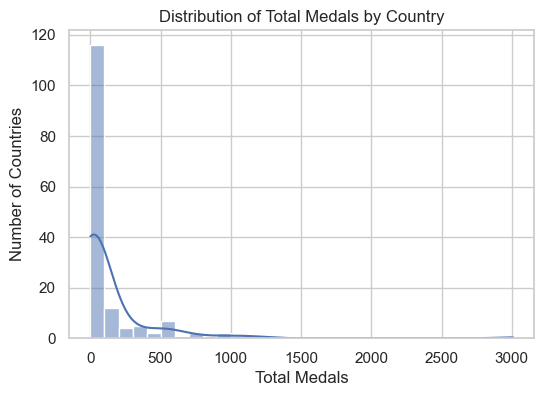

In [703]:
plt.figure(figsize=(6, 4))
sns.histplot(data=df_medals_agg, x='total', bins=30, kde=True)

# Set plot labels and title
plt.xlabel('Total Medals')
plt.ylabel('Number of Countries')
plt.title('Distribution of Total Medals by Country')

# Show the plot
plt.show()

In [699]:
classification_df6 = classification_df5.loc[classification_df5['country_noc'].isin(top_50.country_noc)]
classification_df6.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11523 entries, 0 to 14753
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sex                11523 non-null  object 
 1   height             11523 non-null  float64
 2   weight             11523 non-null  float64
 3   country_noc        11523 non-null  object 
 4   sport              11523 non-null  object 
 5   host_country       11523 non-null  object 
 6   age                11523 non-null  float64
 7   edition_type       11523 non-null  object 
 8   from_host_country  11523 non-null  object 
 9   participation      11523 non-null  object 
 10  won_medal          11523 non-null  int64  
 11  event_cnt          11523 non-null  int64  
 12  olympic_cnt        11523 non-null  int64  
 13  prior_medals       11523 non-null  float64
dtypes: float64(4), int64(3), object(7)
memory usage: 1.3+ MB


In [809]:
#function to evaluate model results 

def evaluate_model(true_labels, predicted_labels, train_true_labels=None, train_predicted_labels=None, model_name=None, model_number=None, results_df=None):
    # Calculate F1 score for test data
    f1 = f1_score(true_labels, predicted_labels)
    
    # Calculate Precision, Recall, and Accuracy for test data
    precision = precision_score(true_labels, predicted_labels)
    recall = recall_score(true_labels, predicted_labels)
    accuracy = accuracy_score(true_labels, predicted_labels)
    
    # Calculate AUC for test data
    fpr, tpr, thresholds = roc_curve(true_labels, predicted_labels)
    roc_auc = auc(fpr, tpr)
    
    # Create a confusion matrix for test data
    cm = confusion_matrix(true_labels, predicted_labels)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 16})
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix (Test Data)')
    plt.show()

    # Plot the ROC curve for test data
    plt.figure(figsize=(5, 5))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve (Test Data)')
    plt.legend(loc='lower right')
    plt.show()
    
    # Calculate F1 score for train data
    train_f1 = f1_score(train_true_labels, train_predicted_labels)
    
    # Save metrics in a DataFrame
    model_results_df = pd.DataFrame({ 
        'Model No.': [model_number],
        'Model': [model_name],
        'F1 Score (Test Data)': [f1],
        'F1 Score (Train Data)': [train_f1],
        'Precision': [precision],
        'Recall': [recall],
        'Accuracy': [accuracy],
        'AUC': [roc_auc]
    })
    
    # Append to the existing results DataFrame
    if results_df is None:
        results_df = model_results_df
    else:
        results_df = pd.concat([results_df, model_results_df], ignore_index=True)
    
    return results_df


In [845]:
def plot_feature_importance(model, X_train, top_n=30):
    #  extract feature names from preprocessir
    if 'preprocessor' in model.named_steps:
        preprocessor = model.named_steps['preprocessor']
        numeric_features = preprocessor.transformers_[0][2]
        categorical_features = preprocessor.transformers_[1][1]\
            .named_steps['onehot'] \
            .get_feature_names_out(preprocessor.transformers_[1][2])
        feature_names = np.concatenate([numeric_features, categorical_features])
    else:
        # If no preprocessor, assume feature names are directly from X_train
        feature_names = X_train.columns

    # Access the feature importances from the model
    feature_importances = model.named_steps['classifier'].feature_importances_

    # Create a dictionary with feature names and their importance scores
    feature_importance_dict = dict(zip(feature_names, feature_importances))

    sorted_feature_importance = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

    # Select the top features
    top_features = dict(sorted_feature_importance[:top_n])

    
    plt.figure(figsize=(12, 8))
    sns.barplot(x=list(top_features.values()), y=list(top_features.keys()), palette='viridis')
    plt.xlabel('Feature Importance')
    plt.ylabel('Features')
    plt.title('Top Feature Importance')
    plt.show()


In [810]:
results_df=pd.DataFrame()

We will leverage the scikit-learn pipeline for our modeling process.

<br>
We will begin by building a baseline random forest model. The features going into the model include:




<table>
  <tr>
    <th>Feature</th>
    <th>Type</th>
    <th>Description</th>
  </tr>
  <tr>
    <td>height</td>
    <td>Numeric</td>
    <td>Height of the athlete</td>
  </tr>
  <tr>
    <td>weight</td>
    <td>Numeric</td>
    <td>Weight of the athlete</td>
  </tr>
  <tr>
    <td>age</td>
    <td>Numeric</td>
    <td>Age of the athlete</td>
  </tr>
  <tr>
    <td>event_cnt</td>
    <td>Numeric</td>
    <td>No. of events the athlete is participating in at the Games</td>
  </tr>
  <tr>
    <td>olympic_cnt</td>
    <td>Numeric</td>
    <td>No. of prior Olympics the athlete has participated in</td>
  </tr>
  <tr>
    <td>prior_medals</td>
    <td>Numeric</td>
    <td>No. of medals won in prior games</td>
  </tr>
  <tr>
    <td>sex</td>
    <td>Categorical</td>
    <td>Male or Female</td>
  </tr>
  <tr>
    <td>country_noc</td>
    <td>Categorical</td>
    <td>Country the athlete is representing</td>
  </tr>
  <tr>
    <td>sport</td>
    <td>Categorical</td>
    <td>Sport the athlete plays</td>
  </tr>
  <tr>
    <td>participation</td>
    <td>Categorical</td>
    <td>Participating in individual, team, or both events</td>
  </tr>
  <tr>
    <td>edition_type</td>
    <td>Categorical</td>
    <td>Summer or Winter Olympics</td>
  </tr>
  <tr>
    <td>from_host_country</td>
    <td>Categorical</td>
    <td>Whether the athlete is from the host country or not</td>
  </tr>
</table>

In [828]:
#baseline model - Random forest

X = classification_df6.drop('won_medal', axis=1)
y = classification_df6['won_medal']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

numeric_features = ['height', 'weight', 'age', 'event_cnt', 'olympic_cnt', 'prior_medals']
categorical_features = ['sex', 'country_noc', 'sport', 'participation', 'edition_type', 'from_host_country']

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Create a preprocessor using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Create the model pipeline
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])


# Fit and predict using the model
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_pred_train = model.predict(X_train)



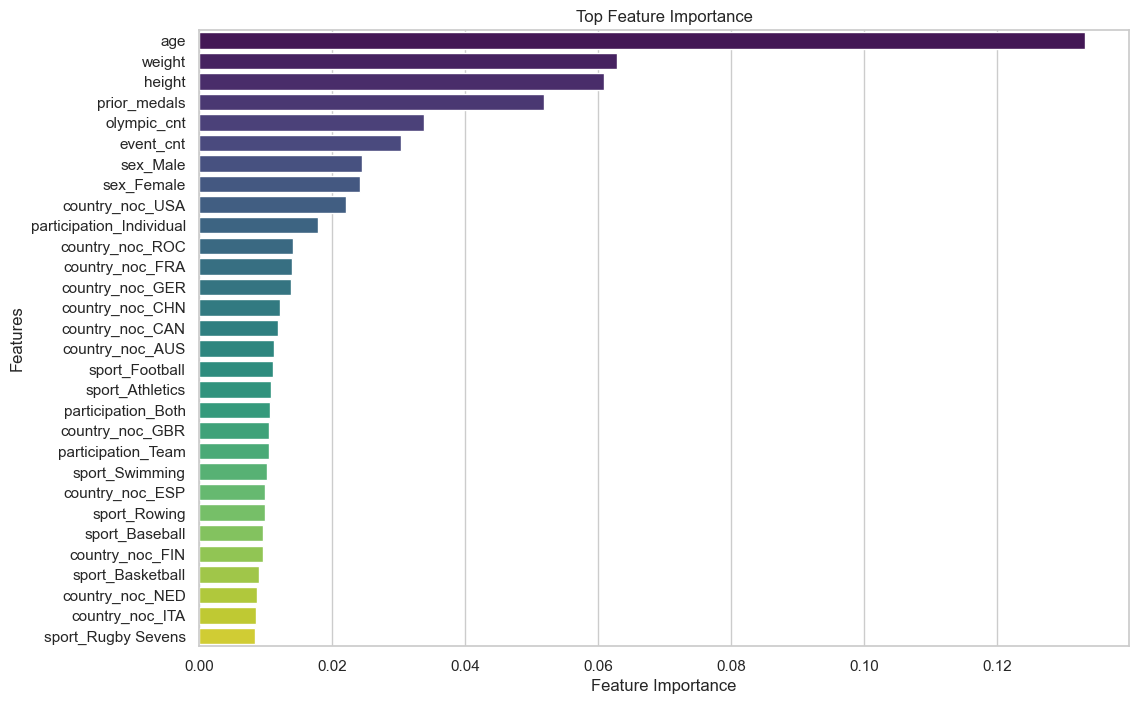

In [846]:
plot_feature_importance(model, X_train)

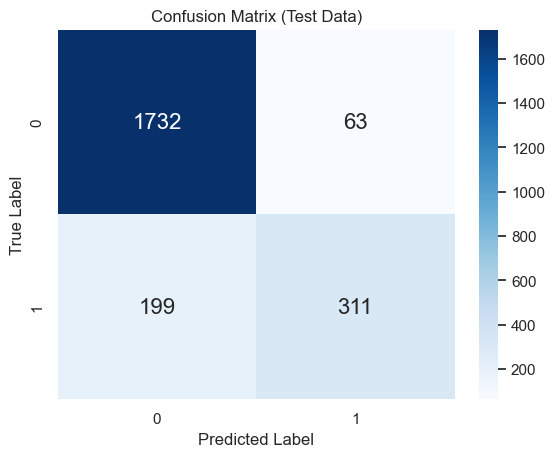

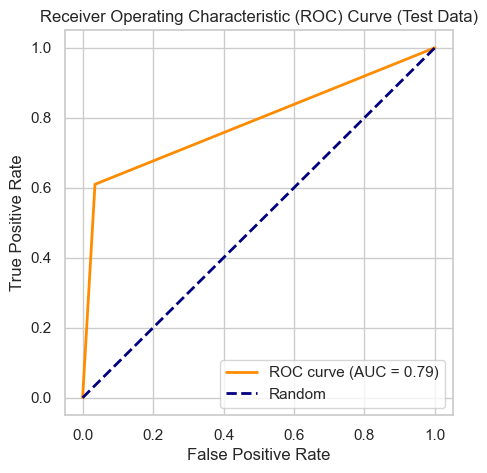

In [812]:
results_df = evaluate_model(y_test, y_pred, y_train, y_pred_train, 'Random Forest', '1', results_df)

In [813]:
results_df

,Model No.,Model,F1 Score (Test Data),F1 Score (Train Data),Precision,Recall,Accuracy,AUC
0,1,Random Forest,0.70362,0.98683,0.83155,0.60980,0.88633,0.78735


This model is over-fitting, it could be due to noisy data, too many features and also the fact that the data is imabalanced. We shall now try over and under sampling to see if that makes a difference.

In [814]:
#Model 1.b with oversampling: try random forest with resampling 

# Oversample the minority class using RandomOverSampler
oversampler = RandomOverSampler(random_state=42)
X_resampled, y_resampled = oversampler.fit_resample(X_train, y_train)

model1b = Pipeline(steps=[('preprocessor', preprocessor),
                        ('classifier', RandomForestClassifier(random_state=42))])

# Fit the model on the resampled data
model1b.fit(X_resampled, y_resampled)


y_pred1b = model1b.predict(X_test)
y_pred1b_train = model1b.predict(X_train)

# print("Accuracy:", accuracy_score(y_test, y_pred1b))
# print("Classification Report:\n", classification_report(y_test, y_pred1b))


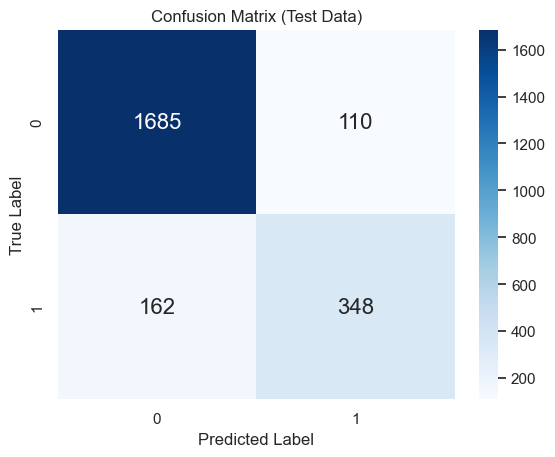

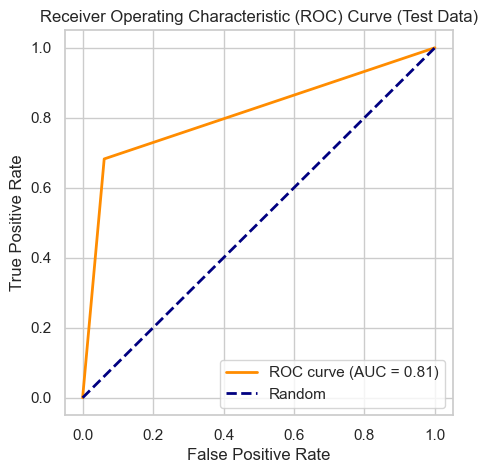

,Model No.,Model,F1 Score (Test Data),F1 Score (Train Data),Precision,Recall,Accuracy,AUC
0,1,Random Forest,0.70362,0.98683,0.83155,0.60980,0.88633,0.78735
1,1b,Random Forest with oversampling,0.71901,0.98462,0.75983,0.68235,0.88200,0.81054


In [815]:
results_df = evaluate_model(y_test, y_pred1b, y_train, y_pred1b_train, 'Random Forest with oversampling', '1b', results_df)
results_df

Oversampling still overfits as measured by the F1 score for the train data. This may be due to the fact that Random Forests, being an ensemble of decision trees, end up memorizing this duplicated information, leading to overfitting. Oversampling can also affect the decision boundaries of individual trees in the Random Forest. If decision boundaries become too tailored to the oversampled instances, the ensemble may struggle to generalize well to new and unseen data.

In [816]:
#Model 1c: Try undersampling


# Undersample the majority class using RandomUnderSampler
undersampler = RandomUnderSampler(random_state=42)
X_underresampled, y_underresampled = undersampler.fit_resample(X_train, y_train)


model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('classifier', RandomForestClassifier(random_state=42))])


model.fit(X_underresampled, y_underresampled)


y_pred1c = model.predict(X_test)
y_pred1c_train = model.predict(X_train)

# print("Accuracy:", accuracy_score(y_test, y_pred1c))
# print("Classification Report:\n", classification_report(y_test, y_pred1c))

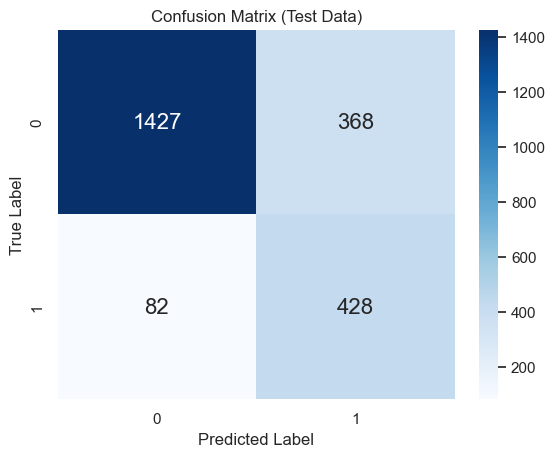

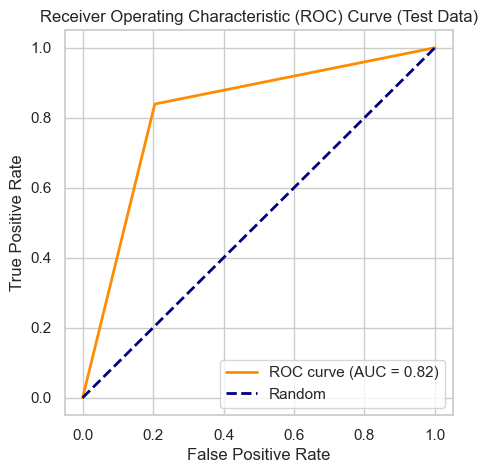

,Model No.,Model,F1 Score (Test Data),F1 Score (Train Data),Precision,Recall,Accuracy,AUC
0,1,Random Forest,0.70362,0.98683,0.83155,0.60980,0.88633,0.78735
1,1b,Random Forest with oversampling,0.71901,0.98462,0.75983,0.68235,0.88200,0.81054
2,1c,Random Forest with undersampling,0.65544,0.77132,0.53769,0.83922,0.80477,0.81710


In [817]:
results_df = evaluate_model(y_test, y_pred1c, y_train, y_pred1c_train, 'Random Forest with undersampling', '1c', results_df)
results_df

Undersampling did not lead to overfitting. Since it involves reducing the number of instances from the majority class, it can simplify the training set and prevent the model from memorizing specific instances and overfitting. This model also has the best AUC of the three but the F1 score on the test set is the worst.


Let us move on to boosting...

In [818]:
#Model 2.1 :XGBoost

model2 = Pipeline(steps=[('preprocessor', preprocessor),
                          ('classifier', xgb.XGBClassifier(random_state=42))])

param_grid = {
    'classifier__max_depth': [3, 5, 7],
    'classifier__learning_rate': [0.01, 0.1, 0.2],
    'classifier__n_estimators': [50, 100, 200],
    'classifier__scale_pos_weight': [None, 4]  # Adjusted scale_pos_weight values to account for imbalance 
}

grid_search = GridSearchCV(model2, param_grid, cv=5, scoring='f1', verbose=1, n_jobs=-1)

grid_search.fit(X_train, y_train)

print("Best Hyperparameters:", grid_search.best_params_)


y_pred2 = grid_search.best_estimator_.predict(X_test)
y_pred2_train = grid_search.best_estimator_.predict(X_train)

print("Accuracy:", accuracy_score(y_test, y_pred2))
print("Classification Report:\n", classification_report(y_test, y_pred2))

Fitting 5 folds for each of 54 candidates, totalling 270 fits
Best Hyperparameters: {'classifier__learning_rate': 0.2, 'classifier__max_depth': 7, 'classifier__n_estimators': 200, 'classifier__scale_pos_weight': 4}
Accuracy: 0.8616052060737527
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.89      0.91      1795
           1       0.66      0.78      0.71       510

    accuracy                           0.86      2305
   macro avg       0.80      0.83      0.81      2305
weighted avg       0.87      0.86      0.87      2305



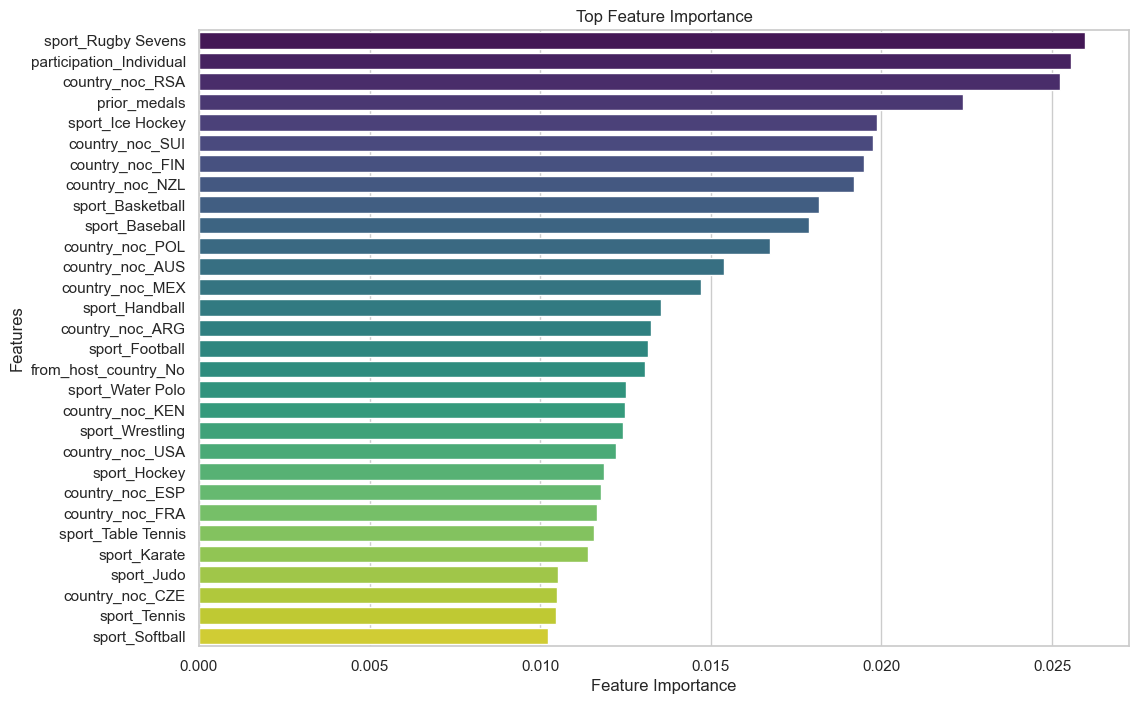

In [847]:
plot_feature_importance(grid_search.best_estimator_, X_train)

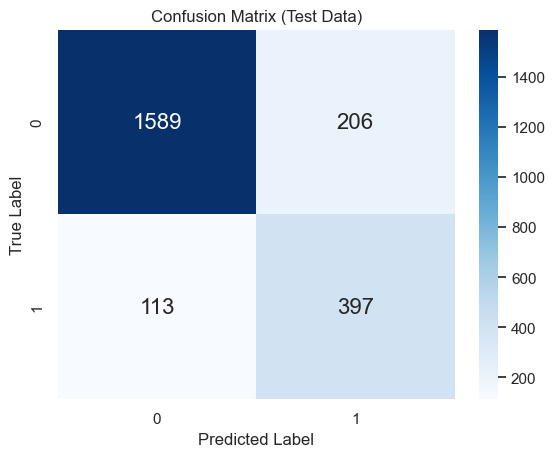

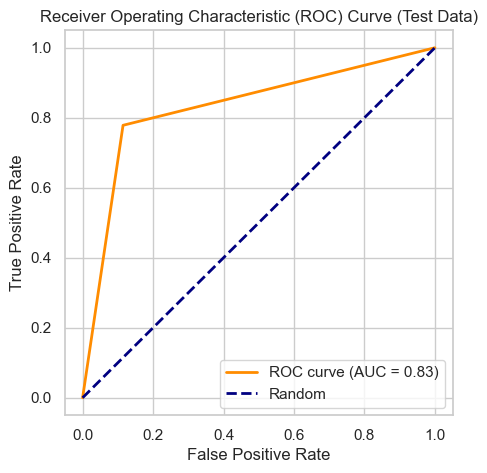

,Model No.,Model,F1 Score (Test Data),F1 Score (Train Data),Precision,Recall,Accuracy,AUC
0,1,Random Forest,0.70362,0.98683,0.83155,0.60980,0.88633,0.78735
1,1b,Random Forest with oversampling,0.71901,0.98462,0.75983,0.68235,0.88200,0.81054
2,1c,Random Forest with undersampling,0.65544,0.77132,0.53769,0.83922,0.80477,0.81710
3,2,XGBoost,0.71339,0.86809,0.65837,0.77843,0.86161,0.83183


In [819]:
results_df = evaluate_model(y_test, y_pred2, y_train, y_pred2_train, 'XGBoost', '2', results_df)
results_df

XGBoost performed the best so far. Since it builds trees sequentially, with each tree correcting the errors of the previous ones, the process often leads to better overall performance compared to the independent learning of trees in Random Forest. Adjusting the scale_pos_weight to account for the imbalance in classes improved model performance significantly. The AUC has also gone up.

Let's try xgboost with oversampling and see what that looks like...

In [820]:
#Model2.2 :XGBoost with oversampling

model2 = Pipeline(steps=[('preprocessor', preprocessor),
                        ('classifier', xgb.XGBClassifier(random_state=42))])


param_grid = {
    'classifier__max_depth': [3, 5, 7],
    'classifier__learning_rate': [0.01, 0.1, 0.2],
    'classifier__n_estimators': [50, 100, 200]
    
}

grid_search = GridSearchCV(model2, param_grid, cv=5, scoring='f1', verbose=1, n_jobs=-1)

grid_search.fit(X_resampled, y_resampled)

print("Best Hyperparameters:", grid_search.best_params_)

# Obtain the best estimator from the grid search
best_model = grid_search.best_estimator_

y_pred2b = best_model.predict(X_test)
y_pred2b_train = best_model.predict(X_train)

print("Accuracy:", accuracy_score(y_test, y_pred2b))
print("Classification Report:\n", classification_report(y_test, y_pred2b))

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best Hyperparameters: {'classifier__learning_rate': 0.2, 'classifier__max_depth': 7, 'classifier__n_estimators': 200}
Accuracy: 0.8611713665943601
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.89      0.91      1795
           1       0.66      0.76      0.71       510

    accuracy                           0.86      2305
   macro avg       0.80      0.82      0.81      2305
weighted avg       0.87      0.86      0.86      2305



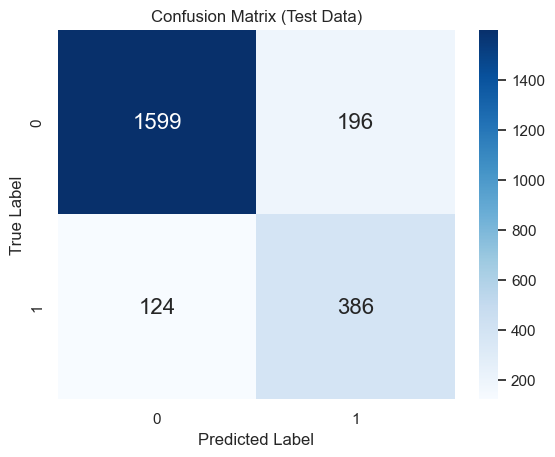

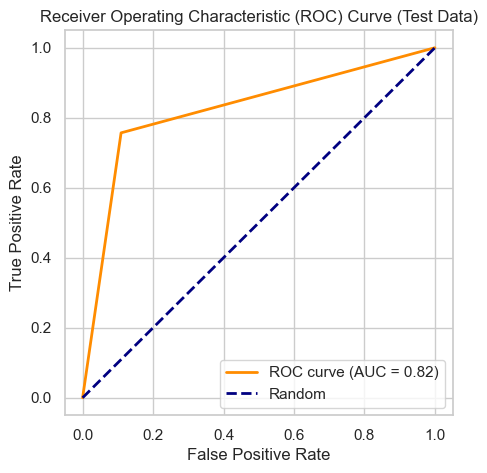

,Model No.,Model,F1 Score (Test Data),F1 Score (Train Data),Precision,Recall,Accuracy,AUC
0,1,Random Forest,0.70362,0.98683,0.83155,0.60980,0.88633,0.78735
1,1b,Random Forest with oversampling,0.71901,0.98462,0.75983,0.68235,0.88200,0.81054
2,1c,Random Forest with undersampling,0.65544,0.77132,0.53769,0.83922,0.80477,0.81710
3,2,XGBoost,0.71339,0.86809,0.65837,0.77843,0.86161,0.83183
4,2b,XGBoost with oversampling,0.70696,0.86705,0.66323,0.75686,0.86117,0.82384


In [821]:
results_df = evaluate_model(y_test, y_pred2b, y_train, y_pred2b_train, 'XGBoost with oversampling', '2b', results_df)
results_df

Adjusting the scale_pos_weight which is part of the algorithm is more efficient than oversampling which is why there is a slight difference in performance.

Let's try bagging now...

In [822]:
#Model3: Bagging with RFC as base_estimator

bagging_model = BaggingClassifier(base_estimator=RandomForestClassifier(random_state=42),
                                  n_estimators=5) 

bagging_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                    ('classifier', bagging_model)])

bagging_pipeline.fit(X_train, y_train)

y_pred3 = bagging_pipeline.predict(X_test)

y_pred3_train = bagging_pipeline.predict(X_train)

                            
print("Accuracy:", accuracy_score(y_test, y_pred3))
print("Classification Report:\n", classification_report(y_test, y_pred3))

Accuracy: 0.8793926247288504
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.97      0.93      1795
           1       0.86      0.54      0.67       510

    accuracy                           0.88      2305
   macro avg       0.87      0.76      0.80      2305
weighted avg       0.88      0.88      0.87      2305



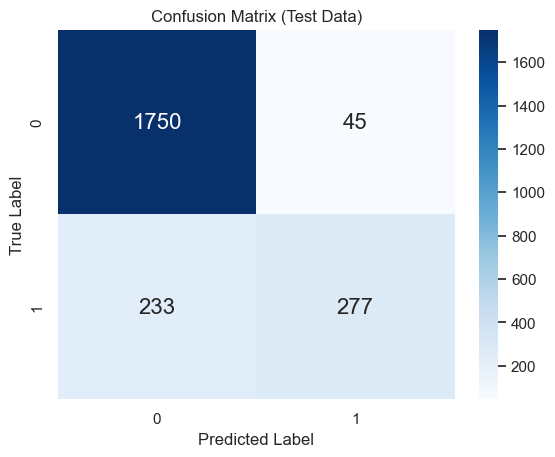

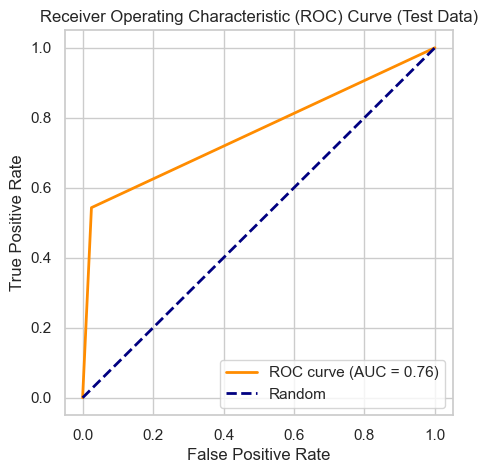

,Model No.,Model,F1 Score (Test Data),F1 Score (Train Data),Precision,Recall,Accuracy,AUC
0,1,Random Forest,0.70362,0.98683,0.83155,0.60980,0.88633,0.78735
1,1b,Random Forest with oversampling,0.71901,0.98462,0.75983,0.68235,0.88200,0.81054
2,1c,Random Forest with undersampling,0.65544,0.77132,0.53769,0.83922,0.80477,0.81710
3,2,XGBoost,0.71339,0.86809,0.65837,0.77843,0.86161,0.83183
4,2b,XGBoost with oversampling,0.70696,0.86705,0.66323,0.75686,0.86117,0.82384
5,3,Bagging,0.66587,0.91069,0.86025,0.54314,0.87939,0.75903


In [823]:
results_df = evaluate_model(y_test, y_pred3, y_train, y_pred3_train, 'Bagging', '3', results_df)
results_df

The bagging model also seems like it was overfitting, but not as much as the Random Forest models. This could be because there is a significant amount of noise in the training data and bagging might inadvertently amplify this noise.

We will also try a Logistic Regression model, athough it is likely to underperform the other models by a mile.

In [824]:
#Model 4 Log reg

log_reg_model = LogisticRegression(random_state=42)

log_reg_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                    ('classifier',log_reg_model)])

log_reg_pipeline.fit(X_train, y_train)

y_pred4 = log_reg_pipeline.predict(X_test)
y_pred4_train = log_reg_pipeline.predict(X_train)

                            
print("Accuracy:", accuracy_score(y_test, y_pred4))
print("Classification Report:\n", classification_report(y_test, y_pred4))

Accuracy: 0.789587852494577
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.97      0.88      1795
           1       0.59      0.17      0.26       510

    accuracy                           0.79      2305
   macro avg       0.69      0.57      0.57      2305
weighted avg       0.76      0.79      0.74      2305



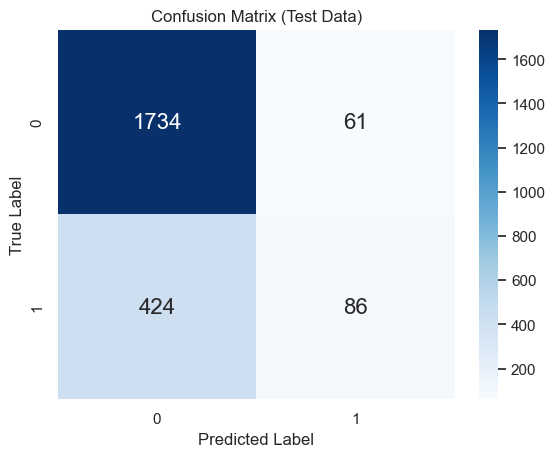

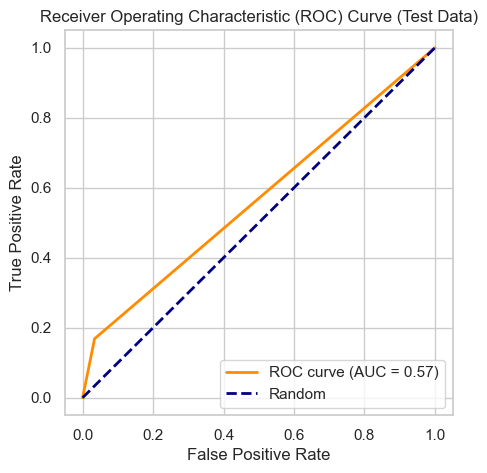

,Model No.,Model,F1 Score (Test Data),F1 Score (Train Data),Precision,Recall,Accuracy,AUC
0,1,Random Forest,0.70362,0.98683,0.83155,0.60980,0.88633,0.78735
1,1b,Random Forest with oversampling,0.71901,0.98462,0.75983,0.68235,0.88200,0.81054
2,1c,Random Forest with undersampling,0.65544,0.77132,0.53769,0.83922,0.80477,0.81710
3,2,XGBoost,0.71339,0.86809,0.65837,0.77843,0.86161,0.83183
4,2b,XGBoost with oversampling,0.70696,0.86705,0.66323,0.75686,0.86117,0.82384
5,3,Bagging,0.66587,0.91069,0.86025,0.54314,0.87939,0.75903
6,4,Logistic Regression,0.26180,0.26998,0.58503,0.16863,0.78959,0.56732


In [825]:
results_df = evaluate_model(y_test, y_pred4, y_train, y_pred4_train, 'Logistic Regression', '4', results_df)
results_df

As expected, Logistic Regression performed poorly compared to the other models. The primary reason for this could be imbalanced data. Also, if the true relationship is highly non-linear, decision tree-based models like random forest or boosting algorithms can capture these non-linearities better and they can better represent the decision boundaries. 

<div style="background-color: #FFFFE0; border: 2px solid #FFD700; padding: 20px;">
    <h2>Conclusion</h2>

Based on the results from the different models, several observations and conclusions can be drawn:

<strong>Random Forest Models: </strong>

The Random Forest model without resampling (Model 1) achieved a high F1 score on the training data (0.98683) but showed a drop in performance on the test data (F1 score: 0.70362), indicating potential overfitting.
Random Forest with oversampling (Model 1b) improved the F1 score on the test data (0.71901), suggesting that oversampling had a positive impact on generalization but there is still overfitting.
Random Forest with undersampling (Model 1c) showed a lower F1 score on the test data (0.65544), indicating that undersampling might not be as effective in this context.
<br> <br>
<strong>
XGBoost Models:</strong>
   <br> <br>
The XGBoost model without resampling (Model 2) achieved a competitive F1 score on the test data (0.71339), and it performed well on both training and test datasets.
XGBoost with oversampling (Model 2b) demonstrated consistent performance on the test data (F1 score: 0.70696) while maintaining a better balance between precision and recall.
<br> <br>
<strong>
Bagging Model:
</strong>
    <br> <br>
The Bagging model (Model 3) achieved a relatively high F1 score on the training data (0.91069) but had lower performance on the test data (F1 score: 0.66587), indicating potential overfitting.
<br> <br>
<strong>
Logistic Regression Model:
</strong>
    <br> <br>
The Logistic Regression model (Model 4) had the lowest F1 score on the test data (0.26180), indicating challenges in correctly identifying positive instances. The precision and recall values are also relatively low.
<br> <br>
<strong>
Recommendation:
</strong>
    <br> <br>
XGBoost without resampling (Model 2) and XGBoost with oversampling (Model 2b) are promising models, demonstrating good generalization performance.
Random Forest with oversampling (Model 1b) also shows improvement over the non-resampled version.
Further exploration of hyperparameter tuning for XGBoost and Random Forest models may lead to improved performance.
<br><br>
    <strong>Future work: </strong><br><br>
Some of the ways we can further enhance these models include - 

1. Hyperparameter tuning - spend more time tuning the models and explore the effect of regularization

2. Additional data - we can explore additional data points like results at other events, age the athlete started training, etc. and assess their impact on model performance 

3. Explore interaction terms - interactions between certain features might have a combined effect on the target
4. Investigate additional features or alternative data preprocessing techniques to enhance the model's ability to capture underlying patterns.
5. Evaluate approaches that combine the strengths of multiple models to achieve better overall performance.
6. Conduct more in-depth analysis of misclassifications to identify specific areas for improvement.

</div>